<a href="https://colab.research.google.com/github/chaitanyakalidindi/assignment5_1/blob/main/prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required Assignment 5.1: Will the Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaurant near where you are driving. Would you accept that coupon and take a short detour to the restaurant? Would you accept the coupon but use it on a subsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaurant? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\$20 - $50).

**Deliverables**

Your final product should be a brief report that highlights the differences between customers who did and did not accept the coupons.  To explore the data you will utilize your knowledge of plotting, statistical summaries, and visualization using Python. You will publish your findings in a public facing github repository as your first portfolio piece.





### Data Description
Keep in mind that these values mentioned below are average values.

The attributes of this data set include:
1. User attributes
    -  Gender: male, female
    -  Age: below 21, 21 to 25, 26 to 30, etc.
    -  Marital Status: single, married partner, unmarried partner, or widowed
    -  Number of children: 0, 1, or more than 1
    -  Education: high school, bachelors degree, associates degree, or graduate degree
    -  Occupation: architecture & engineering, business & financial, etc.
    -  Annual income: less than \\$12500, \\$12500 - \\$24999, \\$25000 - \\$37499, etc.
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she buys takeaway food: 0, less than 1, 1 to 3, 4 to 8 or greater
    than 8
    -  Number of times that he/she goes to a coffee house: 0, less than 1, 1 to 3, 4 to 8 or
    greater than 8
    -  Number of times that he/she eats at a restaurant with average expense less than \\$20 per
    person: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    

2. Contextual attributes
    - Driving destination: home, work, or no urgent destination
    - Location of user, coupon and destination: we provide a map to show the geographical
    location of the user, destination, and the venue, and we mark the distance between each
    two places with time of driving. The user can see whether the venue is in the same
    direction as the destination.
    - Weather: sunny, rainy, or snowy
    - Temperature: 30F, 55F, or 80F
    - Time: 10AM, 2PM, or 6PM
    - Passenger: alone, partner, kid(s), or friend(s)


3. Coupon attributes
    - time before it expires: 2 hours or one day

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import textwrap


### Problems

Use the prompts below to get started with your data analysis.  

1. Read in the `coupons.csv` file.




In [2]:
data = pd.read_csv('data/coupons.csv')


2. Investigate the dataset for missing or problematic data.

In [3]:
#printing null values in each columnn to check for all the missing values
print(data.isnull().sum())

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64


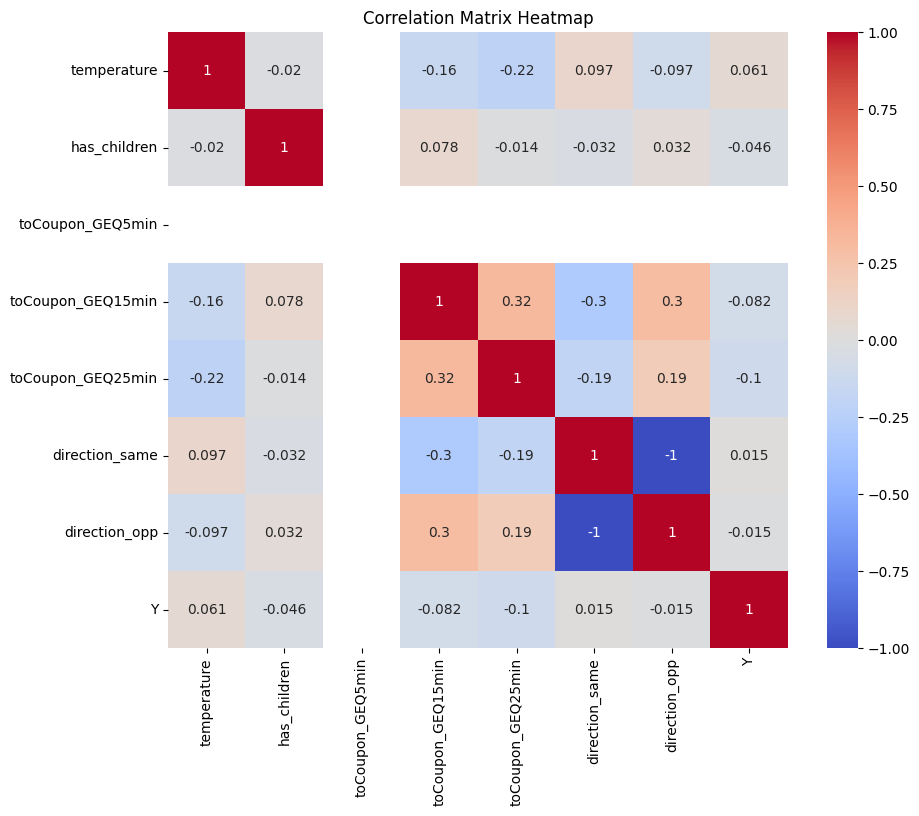

In [4]:
#Draw heat map for the correaltion matrix
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()


3. Decide what to do about your missing data -- drop, replace, other...

In [5]:
#Marking all null values to "dont know"
data["car"]=data["car"].fillna("dont know")
data["Bar"]=data["Bar"].fillna("dont know")
data["CoffeeHouse"]=data["CoffeeHouse"].fillna("dont know")
data["CarryAway"]=data["CarryAway"].fillna("dont know")
data["Restaurant20To50"]=data["Restaurant20To50"].fillna("dont know")
data["RestaurantLessThan20"]=data["RestaurantLessThan20"].fillna("dont know")
#Drop duplicate values
data = data.drop_duplicates()
#Based on correlation matrix direction_same, direction_opp seem to represent the same value(if direction_same=1, direction_opp=0) we can drop direction_opp
data = data.drop(columns=['direction_opp'])

#Drop Car column
data = data.drop(columns=['car'])

#Change the temperature label
data['temperature'] = data['temperature'].replace({30: 'cold(30)', 55: 'warm(55)', 80: 'hot(80)'})

In [6]:
#Assuming toCoupon_GEQ5min stands for the driving distance to the coupon is grater than or equal to 5 min
#Assuming toCoupon_GEQ15min stands for the driving distance to the coupon is grater than or equal to 15 min
#Assuming toCoupon_GEQ25min stands for the driving distance to the coupon is grater than or equal to 25 min
#Combine toCoupon_GEQ5min, toCoupon_GEQ15min, toCoupon_GEQ25min and catogorize them into buckets
def categorize_distance(row):
    geq25 = pd.to_numeric(row.get('toCoupon_GEQ25min'))
    geq15 = pd.to_numeric(row.get('toCoupon_GEQ15min'))
    geq5 = pd.to_numeric(row.get('toCoupon_GEQ5min'))
    if geq25 == 1:
        return '25+ min'
    elif geq15 == 1 and (geq25 is None or geq25 == 0):
        return '15-25 min'
    elif geq5 == 1 and (geq15 is None or geq15 == 0):
        return '5-15 min'
    else:
        return "don't know"

data['distance'] = data.apply(categorize_distance, axis=1)
#Drop toCoupon_GEQ5min, toCoupon_GEQ15min, toCoupon_GEQ25min rows
data = data.drop(columns=['toCoupon_GEQ5min'])
data = data.drop(columns=['toCoupon_GEQ15min'])
data = data.drop(columns=['toCoupon_GEQ25min'])

#Declare plot order for differnt rows
temperature_order = ['cold(30)', 'warm(55)', 'hot(80)']
distance_order = ['5-15 min', '15-25 min', '25+ min']

4. What proportion of the total observations chose to accept the coupon?



In [7]:
acceptance_rate = data['Y'].mean()
print(f"Acceptance Rate: {acceptance_rate:.2f}")

Acceptance Rate: 0.57


5. Use a bar plot to visualize the `coupon` column.

<ipython-input-8-31427c061a78>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title='Accepted (Y)', loc='upper right')


Acceptance Rates:
                  coupon         Y
0                    Bar  0.409950
1  Carry out & Take away  0.733788
2           Coffee House  0.498621
3      Restaurant(20-50)  0.441532
4        Restaurant(<20)  0.707809


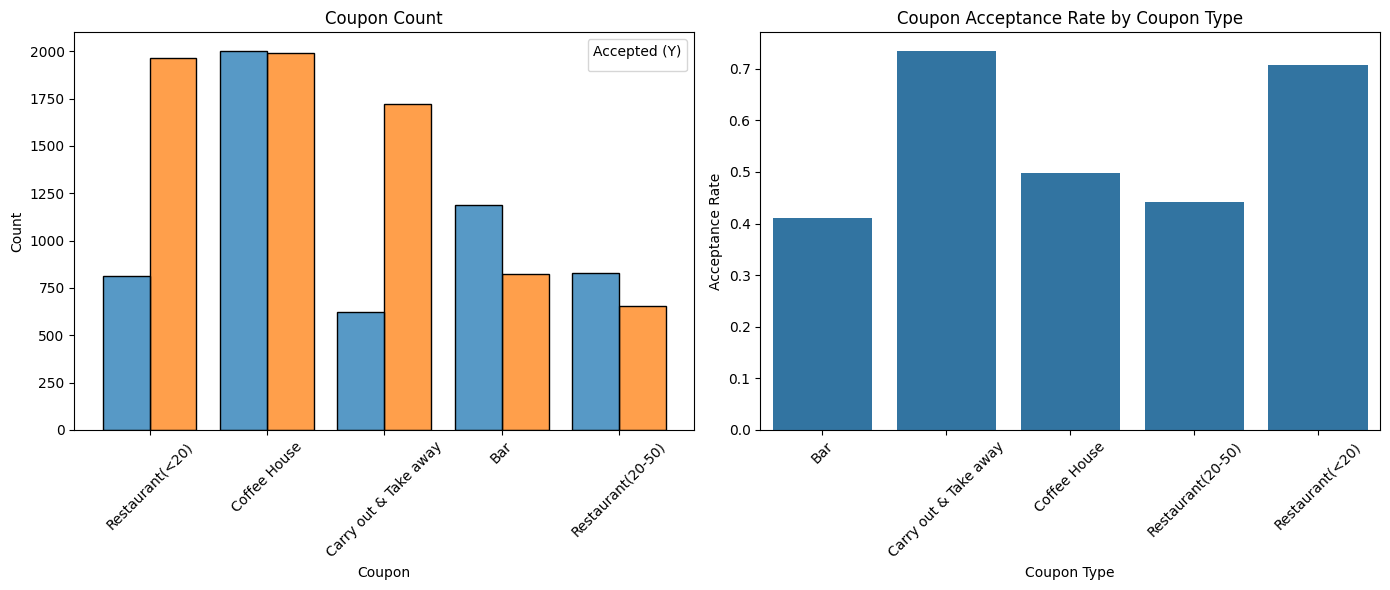

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Create the hist to visualize the coupon count by Y[0,1]
sns.histplot(data=data, x="coupon", hue="Y", multiple="dodge", shrink=.8, ax=axes[0])
axes[0].set_title("Coupon Count")
axes[0].set_xlabel("Coupon")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Accepted (Y)', loc='upper right')

acceptance_rates = data.groupby('coupon')['Y'].mean().reset_index()
print("Acceptance Rates:")
print(acceptance_rates)

# Create the bar to visualize the coupon acceptance rate
sns.barplot(x='coupon', y='Y', data=acceptance_rates, ax=axes[1])
axes[1].set_title('Coupon Acceptance Rate by Coupon Type')
axes[1].set_xlabel('Coupon Type')
axes[1].set_ylabel('Acceptance Rate')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


6. Use a histogram to visualize the temperature column.

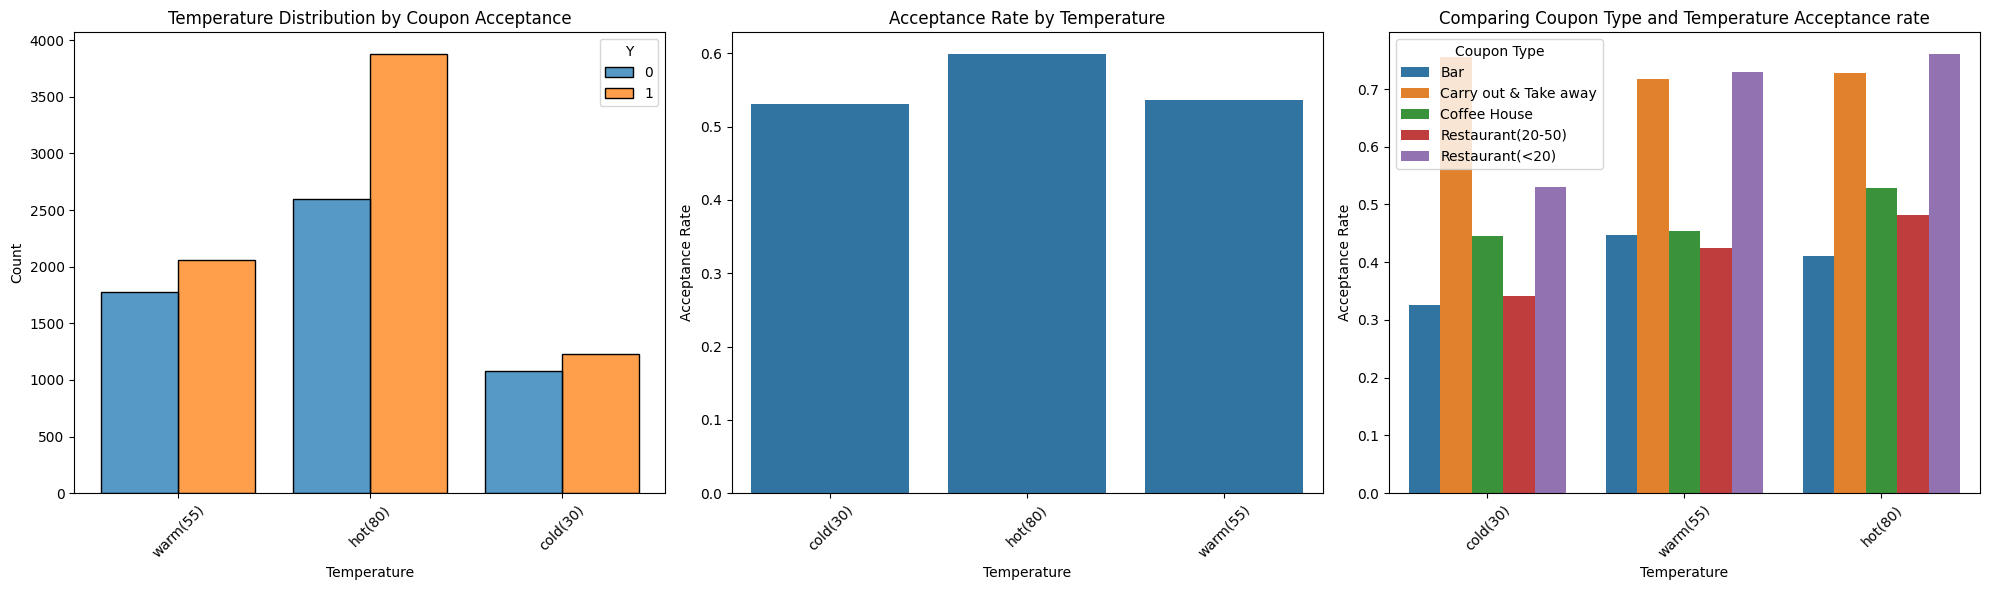

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Histogram  to compare count for each temperature category
sns.histplot(data=data, x="temperature", hue="Y", multiple="dodge", shrink=.8, ax=axes[0])
axes[0].set_title("Temperature Distribution by Coupon Acceptance")
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

acceptance_rates = data.groupby('temperature')['Y'].mean().reset_index()
# Bar chart to compare acceptance rates for each temperature category
sns.barplot(x='temperature', y='Y', data=acceptance_rates, ax=axes[1])
axes[1].set_title('Acceptance Rate by Temperature')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Acceptance Rate')
axes[1].tick_params(axis='x', rotation=45)

# Group by temperature and coupon type, Bar chart to observe temperature and coupon affect each other
acceptance_rates = data.groupby(['temperature', 'coupon'])['Y'].mean().reset_index()
sns.barplot(x='temperature', y='Y', hue='coupon',order=temperature_order, data=acceptance_rates, ax=axes[2])
axes[2].set_title('Comparing Coupon Type and Temperature Acceptance rate')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Acceptance Rate')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title='Coupon Type')
plt.tight_layout()
plt.show()

The above charts show that when cold people like to go for "Carry out & Take away" options. When hot people tend to go more too coffee houses anf when warm(55) people have a more balanced aceepting accross catogories. Restaurants <20 seem to do well at all temperatures.

**Investigating the Bar Coupons**

Now, we will lead you through an exploration of just the bar related coupons.  

1. Create a new `DataFrame` that contains just the bar coupons.


In [10]:
barsubset=data.loc[data["coupon"]=="Bar"]

2. What proportion of bar coupons were accepted?


Acceptance Rates:
coupon
Bar    0.40995
Name: Y, dtype: float64


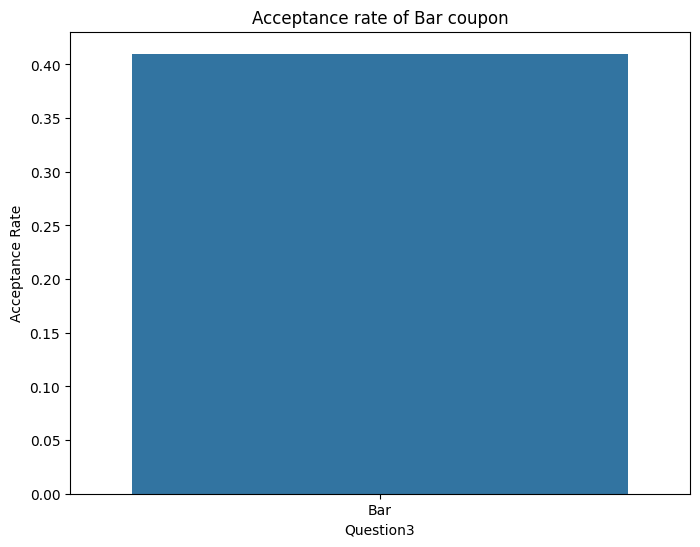

In [11]:
#bar coupons were acceptence rate
group_acceptance_rates = barsubset.groupby('coupon')['Y'].mean()
print("Acceptance Rates:")
print(group_acceptance_rates)
plt.figure(figsize=(8, 6))
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values)
plt.title('Acceptance rate of Bar coupon')
plt.xlabel('Question3')
plt.ylabel('Acceptance Rate')
plt.show()


3. Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.


*   List item
*   List item



<ipython-input-12-6208a0ee5fb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barsubset['question3'] =(barsubset['Bar'].isin(['4~8', 'gt8']))


Acceptance Rates:
question3
False    0.370514
True     0.768844
Name: Y, dtype: float64


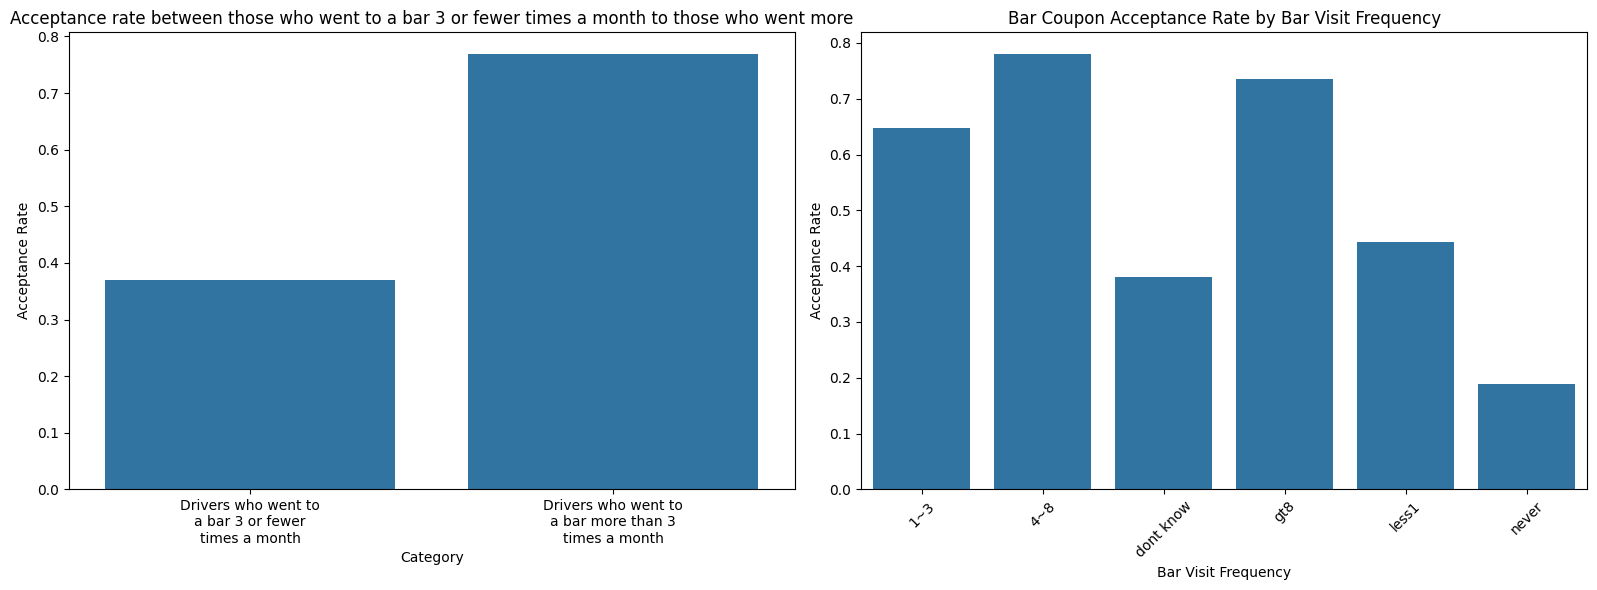

In [12]:
#bar coupons were acceptence rate between those who went to a bar 3 or fewer times a month to those who went more
barsubset['question3'] =(barsubset['Bar'].isin(['4~8', 'gt8']))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Bar chart to compare acceptance rate for each category
group_acceptance_rates = barsubset.groupby('question3')['Y'].mean()
print("Acceptance Rates:")
print(group_acceptance_rates)
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values, ax=axes[0])
axes[0].set_title('Acceptance rate between those who went to a bar 3 or fewer times a month to those who went more')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Acceptance Rate')
axes[0].set_xticks(ticks=[0, 1])
axes[0].set_xticklabels([textwrap.fill('Drivers who went to a bar 3 or fewer times a month', 20), textwrap.fill('Drivers who went to a bar more than 3 times a month', 20)])

# Bar chart to compare acceptance rate for invididual bar frequency
acceptance_rates = barsubset.groupby('Bar')['Y'].mean().reset_index()
sns.barplot(x='Bar', y='Y', data=acceptance_rates, ax=axes[1])
axes[1].set_title('Bar Coupon Acceptance Rate by Bar Visit Frequency')
axes[1].set_xlabel('Bar Visit Frequency')
axes[1].set_ylabel('Acceptance Rate')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


4. Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others.  Is there a difference?


Acceptence rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others:
question4
False    0.334591
True     0.695238
Name: Y, dtype: float64


<ipython-input-13-0e9292281ac7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barsubset['question4'] = (barsubset['age'].isin(['26', '31', '50plus', '36', '41', '46'])) & (barsubset['Bar'].isin(['1~3', '4~8', 'gt8']))


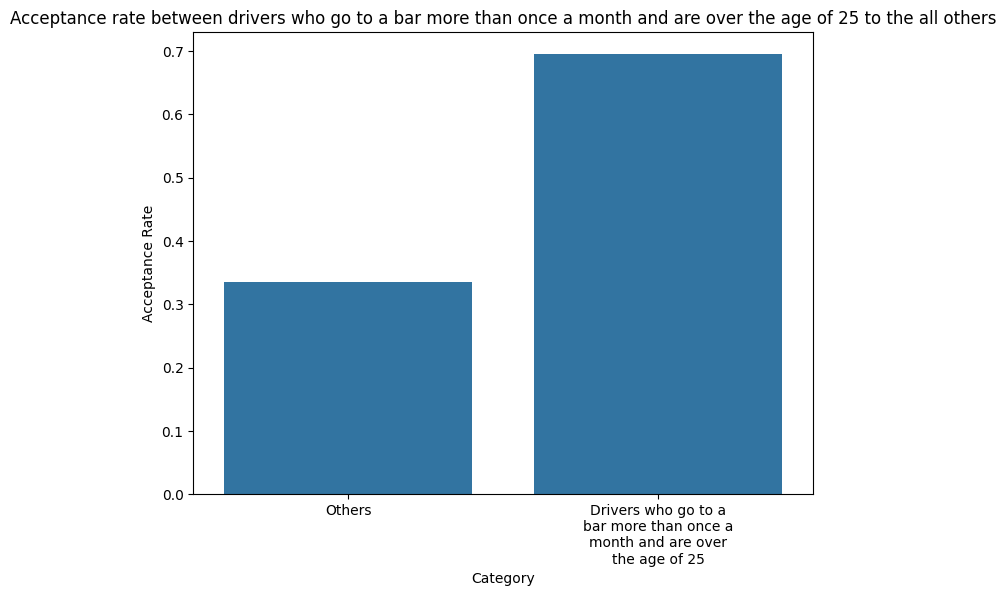

In [13]:
#bar coupons were acceptence rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others
barsubset['question4'] = (barsubset['age'].isin(['26', '31', '50plus', '36', '41', '46'])) & (barsubset['Bar'].isin(['1~3', '4~8', 'gt8']))

# Bar chart to compare acceptance rate for each category
group_acceptance_rates = barsubset.groupby('question4')['Y'].mean()
print("Acceptence rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others:")
print(group_acceptance_rates)
plt.figure(figsize=(8, 6))
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values)
plt.title('Acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others')
plt.xlabel('Category')
plt.ylabel('Acceptance Rate')
plt.xticks(ticks=[1, 0], labels=[textwrap.fill('Drivers who go to a bar more than once a month and are over the age of 25', 20), textwrap.fill('Others', 20)])
plt.show()



5. Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry.


Acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry:
question5
False    0.295408
True     0.713249
Name: Y, dtype: float64


<ipython-input-14-ab921245ea5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barsubset['question5'] = (barsubset['Bar'].isin(['1~3', '4~8', 'gt8'])) & (~barsubset['passanger'].isin(['Kid(s)'])) & (~barsubset['occupation'].isin(['Farming Fishing & Forestry']))


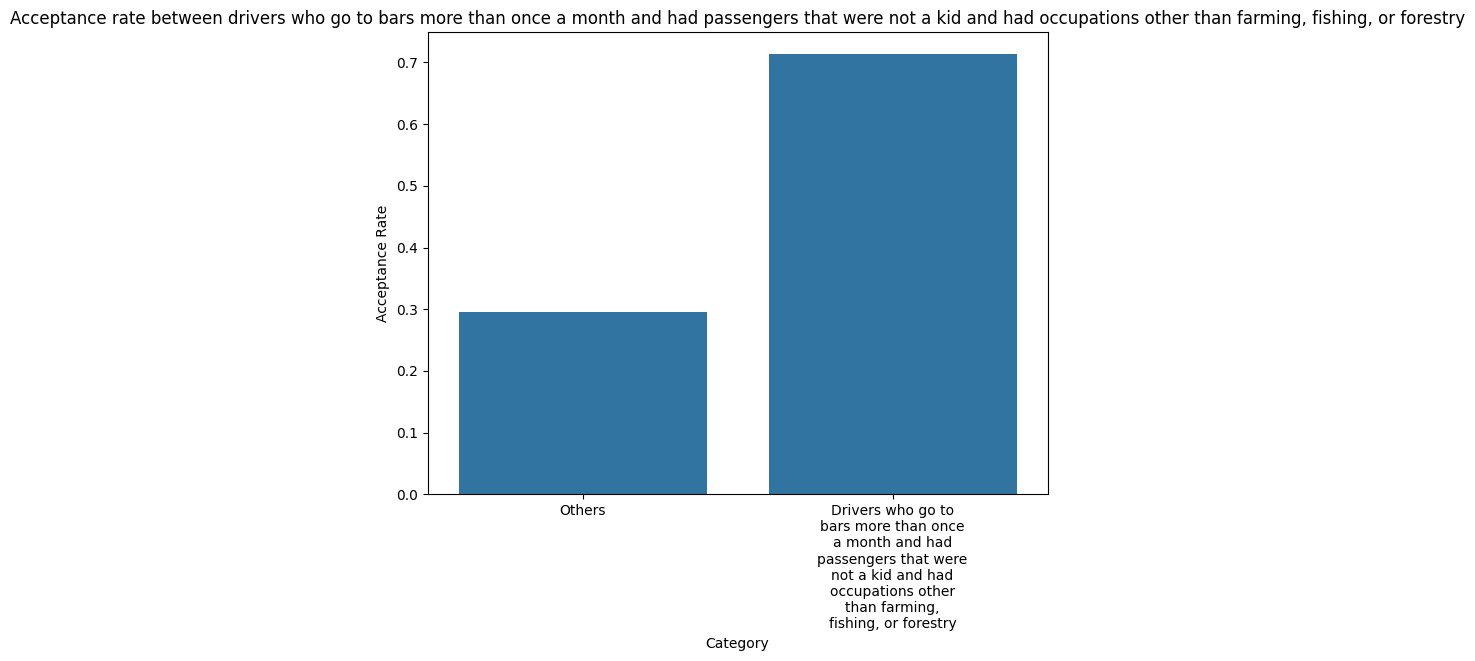

In [14]:
#compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestr
barsubset['question5'] = (barsubset['Bar'].isin(['1~3', '4~8', 'gt8'])) & (~barsubset['passanger'].isin(['Kid(s)'])) & (~barsubset['occupation'].isin(['Farming Fishing & Forestry']))

# Bar chart to Acceptance Rate for each category
group_acceptance_rates = barsubset.groupby('question5')['Y'].mean()
print("Acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry:")
print(group_acceptance_rates)

plt.figure(figsize=(8, 6))
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values)
plt.title('Acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry')
plt.xlabel('Category')
plt.ylabel('Acceptance Rate')
plt.xticks(ticks=[1, 0], labels=[textwrap.fill('Drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry', 20), textwrap.fill('Others', 20)])
plt.show()

6. Compare the acceptance rates between those drivers who:

- go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- go to bars more than once a month and are under the age of 30 *OR*
- go to cheap restaurants more than 4 times a month and income is less than 50K.



<ipython-input-15-0d8c4dae8c81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barsubset['question6a1'] = (barsubset['Bar'].isin(['1~3', '4~8', 'gt8'])) & (~barsubset['passanger'].isin(['Kid(s)'])) & (~barsubset['maritalStatus'].isin(['Widowed']))


Acceptance rates between those go to bars more than once a month, had passengers that were not a kid, and were not widowed and others:
question6a1
False    0.295408
True     0.713249
Name: Y, dtype: float64


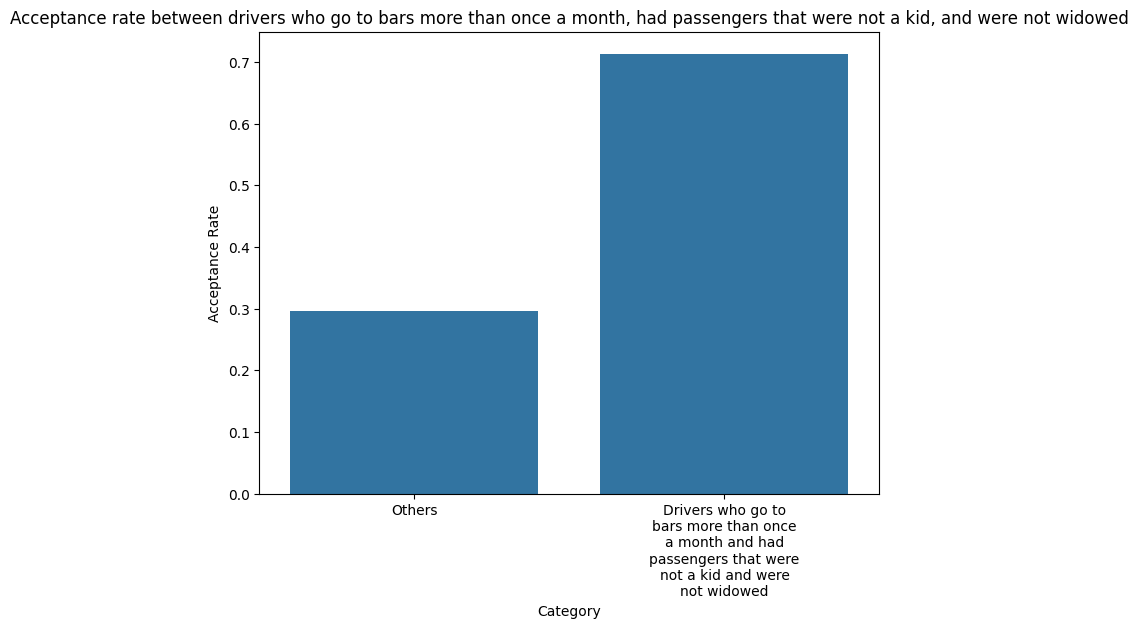

In [15]:
#go to bars more than once a month, had passengers that were not a kid, and were not widowed
barsubset['question6a1'] = (barsubset['Bar'].isin(['1~3', '4~8', 'gt8'])) & (~barsubset['passanger'].isin(['Kid(s)'])) & (~barsubset['maritalStatus'].isin(['Widowed']))
# Bar chart to compare Acceptance Rate for each category
group_acceptance_rates = barsubset.groupby('question6a1')['Y'].mean()
print("Acceptance rates between those go to bars more than once a month, had passengers that were not a kid, and were not widowed and others:")
print(group_acceptance_rates)
plt.figure(figsize=(8, 6))
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values)
plt.title('Acceptance rate between drivers who go to bars more than once a month, had passengers that were not a kid, and were not widowed')
plt.xlabel('Category')
plt.ylabel('Acceptance Rate')
plt.xticks(ticks=[1, 0], labels=[textwrap.fill('Drivers who go to bars more than once a month and had passengers that were not a kid and were not widowed', 20), textwrap.fill('Others', 20)])
plt.show()


Acceptance rates between those go to bars more than once a month and are under the age of 30 and others:
question6b1
False    0.345345
True     0.721739
Name: Y, dtype: float64


<ipython-input-16-47b7c644481d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barsubset['question6b1'] = (barsubset['Bar'].isin(['1~3', '4~8', 'gt8'])) & (~barsubset['age'].isin(['31','50plus','36','41','46']))


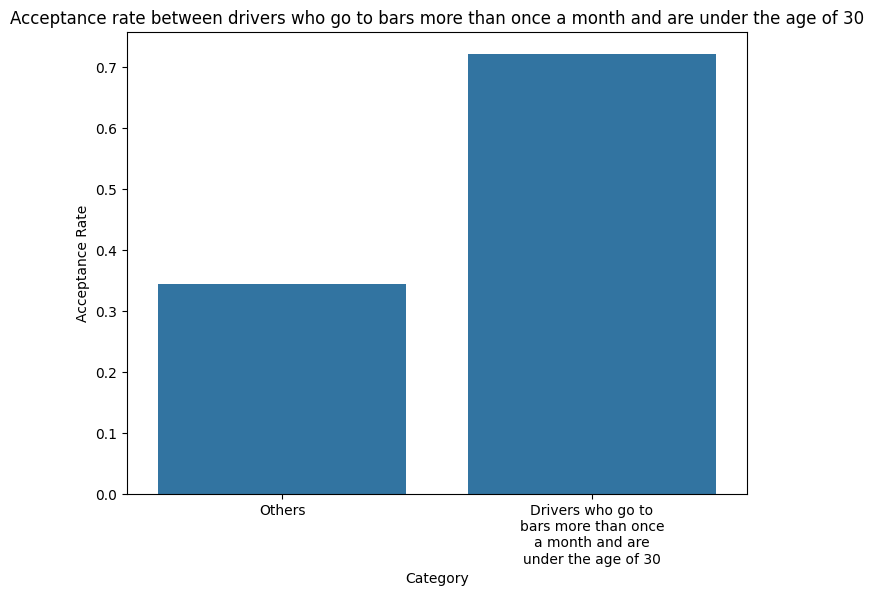

In [16]:
#go to bars more than once a month and are under the age of 30
barsubset['question6b1'] = (barsubset['Bar'].isin(['1~3', '4~8', 'gt8'])) & (~barsubset['age'].isin(['31','50plus','36','41','46']))
group_acceptance_rates = barsubset.groupby('question6b1')['Y'].mean()
# Bar chart to compare Acceptance Rate for each category
print("Acceptance rates between those go to bars more than once a month and are under the age of 30 and others:")
print(group_acceptance_rates)
plt.figure(figsize=(8, 6))
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values)
plt.title('Acceptance rate between drivers who go to bars more than once a month and are under the age of 30')
plt.xlabel('Category')
plt.ylabel('Acceptance Rate')
plt.xticks(ticks=[1, 0], labels=[textwrap.fill('Drivers who go to bars more than once a month and are under the age of 30 ', 20), textwrap.fill('Others', 20)])
plt.show()

Acceptance Rates:
question6c1
False    0.400960
True     0.453488
Name: Y, dtype: float64


<ipython-input-17-f056f3c1adfc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barsubset['question6c1'] = (barsubset['RestaurantLessThan20'].isin(['4~8', 'gt8'])) & (barsubset['income'].isin(['Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999']))


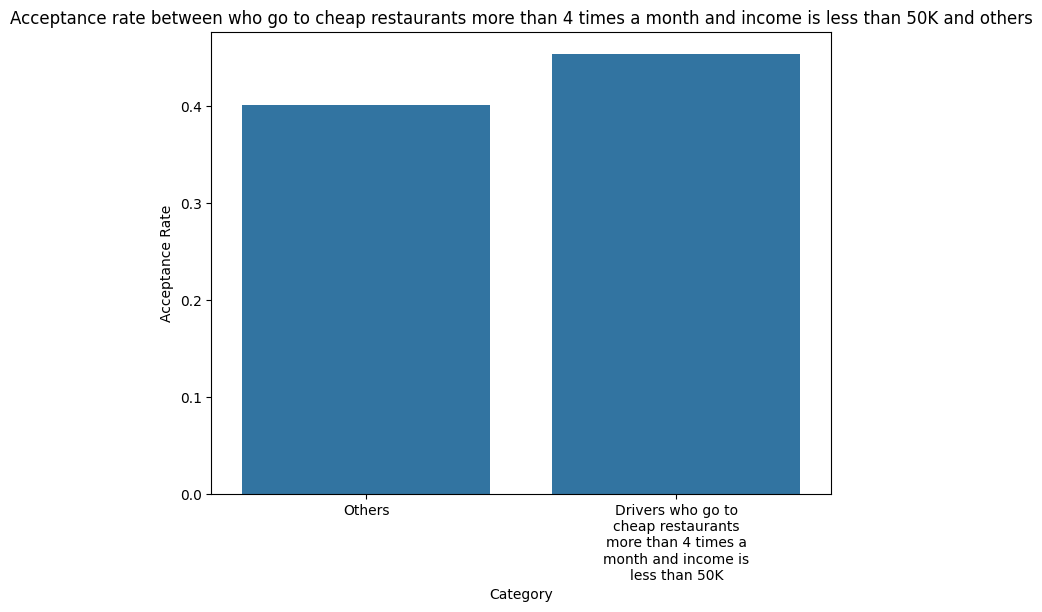

In [17]:
#go to cheap restaurants more than 4 times a month and income is less than 50K.
# Bar chart to compare Acceptance Rate for each category
barsubset['question6c1'] = (barsubset['RestaurantLessThan20'].isin(['4~8', 'gt8'])) & (barsubset['income'].isin(['Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999']))
group_acceptance_rates = barsubset.groupby('question6c1')['Y'].mean()
# Bar chart to compare Acceptance Rate for each category
print("Acceptance Rates:")
print(group_acceptance_rates)
plt.figure(figsize=(8, 6))
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values)
plt.title('Acceptance rate between who go to cheap restaurants more than 4 times a month and income is less than 50K and others')
plt.xlabel('Category')
plt.ylabel('Acceptance Rate')
plt.xticks(ticks=[1, 0], labels=[textwrap.fill('Drivers who go to cheap restaurants more than 4 times a month and income is less than 50K', 20), textwrap.fill('Others', 20)])
plt.show()

7.  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

In [ ]:
#The bar coupon acceptance rate seems to be high(over 70%) for people who alteast go to bar more than once a month

### Independent Investigation

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.  

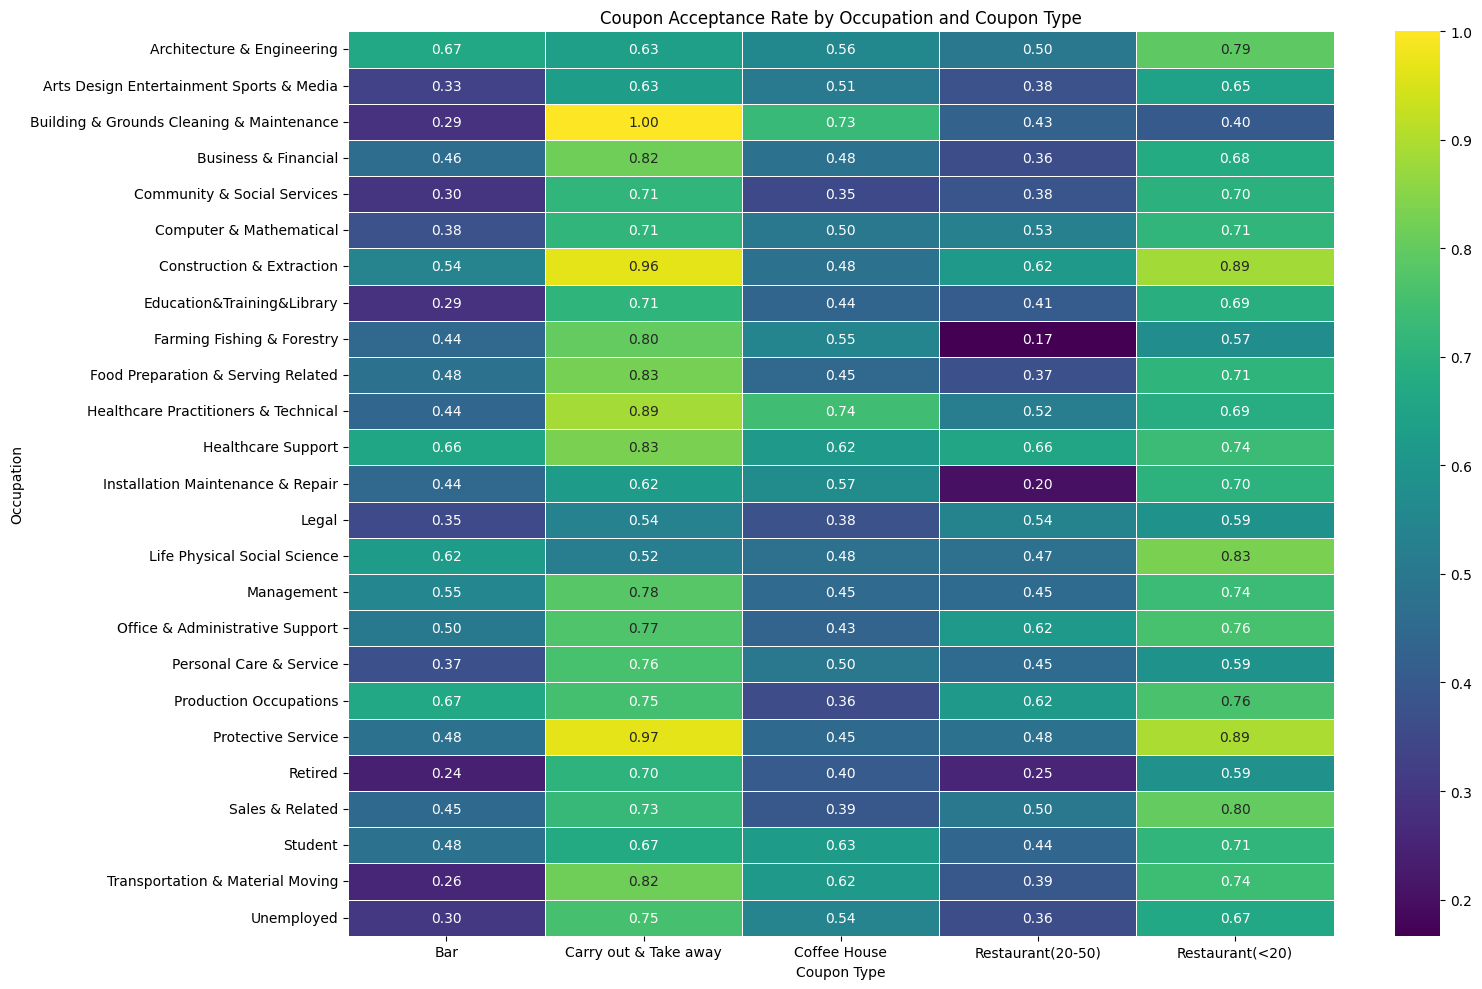

In [18]:
#time based analysis
time_order = ['7AM', '10AM', '2PM', '6PM', '10PM']
distance_order = ['5-15 min', '15-25 min', '25+ min']

# Calculate acceptance rates for each occupation and coupon combination
acceptance_rates_occupation_coupon = data.groupby(['occupation', 'coupon'])['Y'].mean().reset_index()

table = acceptance_rates_occupation_coupon.pivot_table(index='occupation', columns='coupon', values='Y')

# Create a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(table, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Coupon Acceptance Rate by Occupation and Coupon Type')
plt.xlabel('Coupon Type')
plt.ylabel('Occupation')
plt.tight_layout()
plt.show()

In [19]:
# Divide age column into diffent age_groups and assign to new column
def age_to_group(age):
    if age == 'below21':
        return 'below21'
    elif age == '50plus':
        return '50+'
    elif age in ['21', '26']:
        return '21-30'
    elif age in ['31', '36']:
        return '31-40'
    elif age in ['41', '46']:
        return '41-50'
    else:
        return np.nan
data['age_group'] = data['age'].apply(age_to_group)
print(data['age_group'].value_counts() )
age_order = ['below21', '21-30', '31-40', '41-50', '50+']


age_group
21-30      5190
31-40      3336
50+        1781
41-50      1759
below21     544
Name: count, dtype: int64


Acceptance Rates:
coupon
Restaurant(<20)    0.707809
Name: Y, dtype: float64


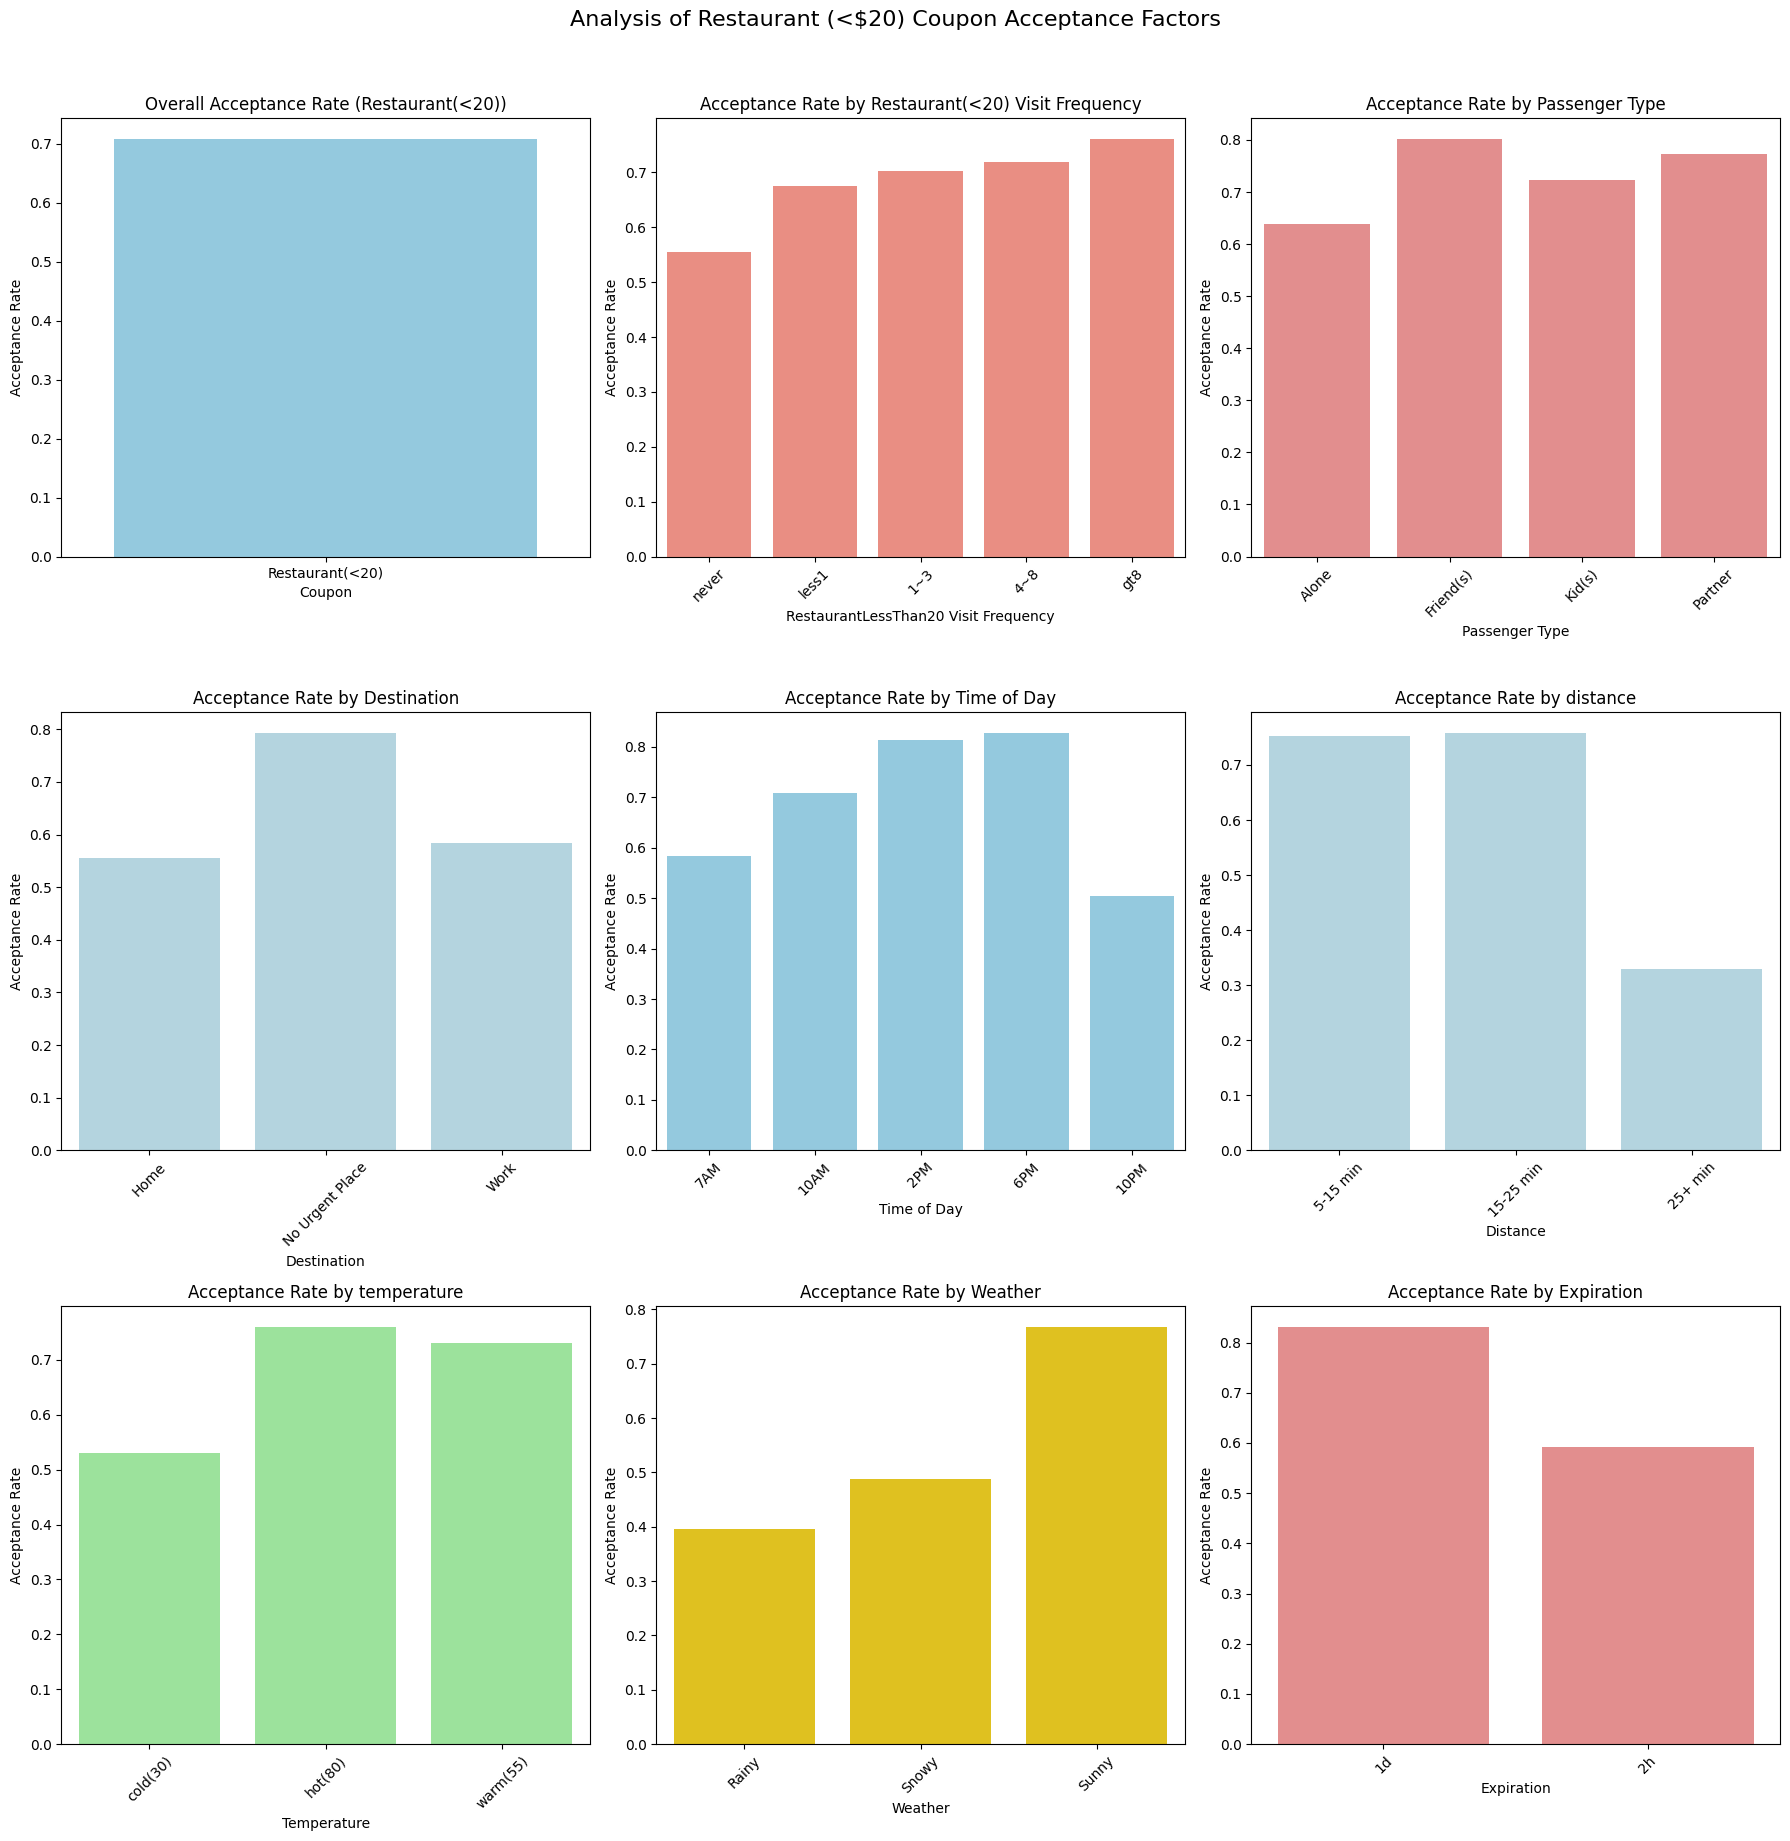

In [20]:
# Filter for Restaurant(<20) coupons
resturant20subsetsubset = data.loc[data["coupon"] == "Restaurant(<20)"]
# Calculate overall acceptance rate for Restaurant(<20) coupons
group_acceptance_rates = resturant20subsetsubset.groupby('coupon')['Y'].mean()
acceptance_rates_by_frequency = resturant20subsetsubset.groupby('RestaurantLessThan20')['Y'].mean().reset_index()
acceptance_rates_by_income = resturant20subsetsubset.groupby('income')['Y'].mean().reset_index()
acceptance_rates_by_age = resturant20subsetsubset.groupby('age_group')['Y'].mean().reset_index()
acceptance_rates_by_passenger = resturant20subsetsubset.groupby('passanger')['Y'].mean().reset_index()
acceptance_rates_by_destination = resturant20subsetsubset.groupby('destination')['Y'].mean().reset_index()
acceptance_rates_by_education = resturant20subsetsubset.groupby('education')['Y'].mean().reset_index()
acceptance_rates_by_time = resturant20subsetsubset.groupby('time')['Y'].mean().reset_index()
acceptance_rates_by_distance = resturant20subsetsubset.groupby('distance')['Y'].mean().reset_index()
acceptance_rates_by_weather = resturant20subsetsubset.groupby('weather')['Y'].mean().reset_index()
acceptance_rates_by_expiration = resturant20subsetsubset.groupby('expiration')['Y'].mean().reset_index()
acceptance_rates_by_gender = resturant20subsetsubset.groupby('gender')['Y'].mean().reset_index()
acceptance_rates_by_occupation = resturant20subsetsubset.groupby('occupation')['Y'].mean().reset_index()
acceptance_rates_by_maritalStatus = resturant20subsetsubset.groupby('maritalStatus')['Y'].mean().reset_index()
acceptance_rates_temperature_coupon = resturant20subsetsubset.groupby('temperature')['Y'].mean().reset_index()

print("Acceptance Rates:")
print(group_acceptance_rates)

colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightblue', 'plum']

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Analysis of Restaurant (<$20) Coupon Acceptance Factors', fontsize=16, y=1.02)
# Subplot 1: Overall Acceptance Rate
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values, ax=axes[0, 0], color=colors[0])
axes[0, 0].set_title('Overall Acceptance Rate (Restaurant(<20))')
axes[0, 0].set_xlabel('Coupon')
axes[0, 0].set_ylabel('Acceptance Rate')

# Subplot 2: Acceptance Rate by CoffeeHouse Visit Frequency
frequency_order = ['never', 'less1', '1~3', '4~8', 'gt8']
sns.barplot(x='RestaurantLessThan20', y='Y', data=acceptance_rates_by_frequency, order=frequency_order, ax=axes[0, 1], color=colors[1])
axes[0, 1].set_title('Acceptance Rate by Restaurant(<20) Visit Frequency')
axes[0, 1].set_xlabel('RestaurantLessThan20 Visit Frequency')
axes[0, 1].set_ylabel('Acceptance Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Subplot 3: Acceptance Rate by Passenger Type
sns.barplot(x='passanger', y='Y', data=acceptance_rates_by_passenger, ax=axes[0, 2], color=colors[4])
axes[0, 2].set_title('Acceptance Rate by Passenger Type')
axes[0, 2].set_xlabel('Passenger Type')
axes[0, 2].set_ylabel('Acceptance Rate')
axes[0, 2].tick_params(axis='x', rotation=45)

# Subplot 4: Acceptance Rate by Destination
sns.barplot(x='destination', y='Y', data=acceptance_rates_by_destination, ax=axes[1, 0], color=colors[5])
axes[1, 0].set_title('Acceptance Rate by Destination')
axes[1, 0].set_xlabel('Destination')
axes[1, 0].set_ylabel('Acceptance Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# Subplot 5: Acceptance Rate by Time of Day
sns.barplot(x='time', y='Y', data=acceptance_rates_by_time, order=time_order, ax=axes[1, 1], color=colors[0])
axes[1, 1].set_title('Acceptance Rate by Time of Day')
axes[1, 1].set_xlabel('Time of Day')
axes[1, 1].set_ylabel('Acceptance Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# Subplot 6: Acceptance Rate by distance
sns.barplot(x='distance', y='Y', data=acceptance_rates_by_distance, order=distance_order, ax=axes[1, 2], color=colors[5])
axes[1, 2].set_title('Acceptance Rate by distance')
axes[1, 2].set_xlabel('Distance')
axes[1, 2].set_ylabel('Acceptance Rate')
axes[1, 2].tick_params(axis='x', rotation=45)

# Subplot 7: Acceptance Rate by Temperature
sns.barplot(x='temperature', y='Y', data=acceptance_rates_temperature_coupon, ax=axes[2, 0], color=colors[2])
axes[2, 0].set_title('Acceptance Rate by temperature')
axes[2, 0].set_xlabel('Temperature')
axes[2, 0].set_ylabel('Acceptance Rate')
axes[2, 0].tick_params(axis='x', rotation=45)

# Subplot 8: Acceptance Rate by Weather
sns.barplot(x='weather', y='Y', data=acceptance_rates_by_weather, ax=axes[2, 1], color=colors[3])
axes[2, 1].set_title('Acceptance Rate by Weather')
axes[2, 1].set_xlabel('Weather')
axes[2, 1].set_ylabel('Acceptance Rate')
axes[2, 1].tick_params(axis='x', rotation=45)

# Subplot 9: Acceptance Rate by Expiration
sns.barplot(x='expiration', y='Y', data=acceptance_rates_by_expiration, ax=axes[2, 2], color=colors[4])
axes[2, 2].set_title('Acceptance Rate by Expiration')
axes[2, 2].set_xlabel('Expiration')
axes[2, 2].set_ylabel('Acceptance Rate')
axes[2, 2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Acceptance Rates:
coupon
Restaurant(20-50)    0.441532
Name: Y, dtype: float64


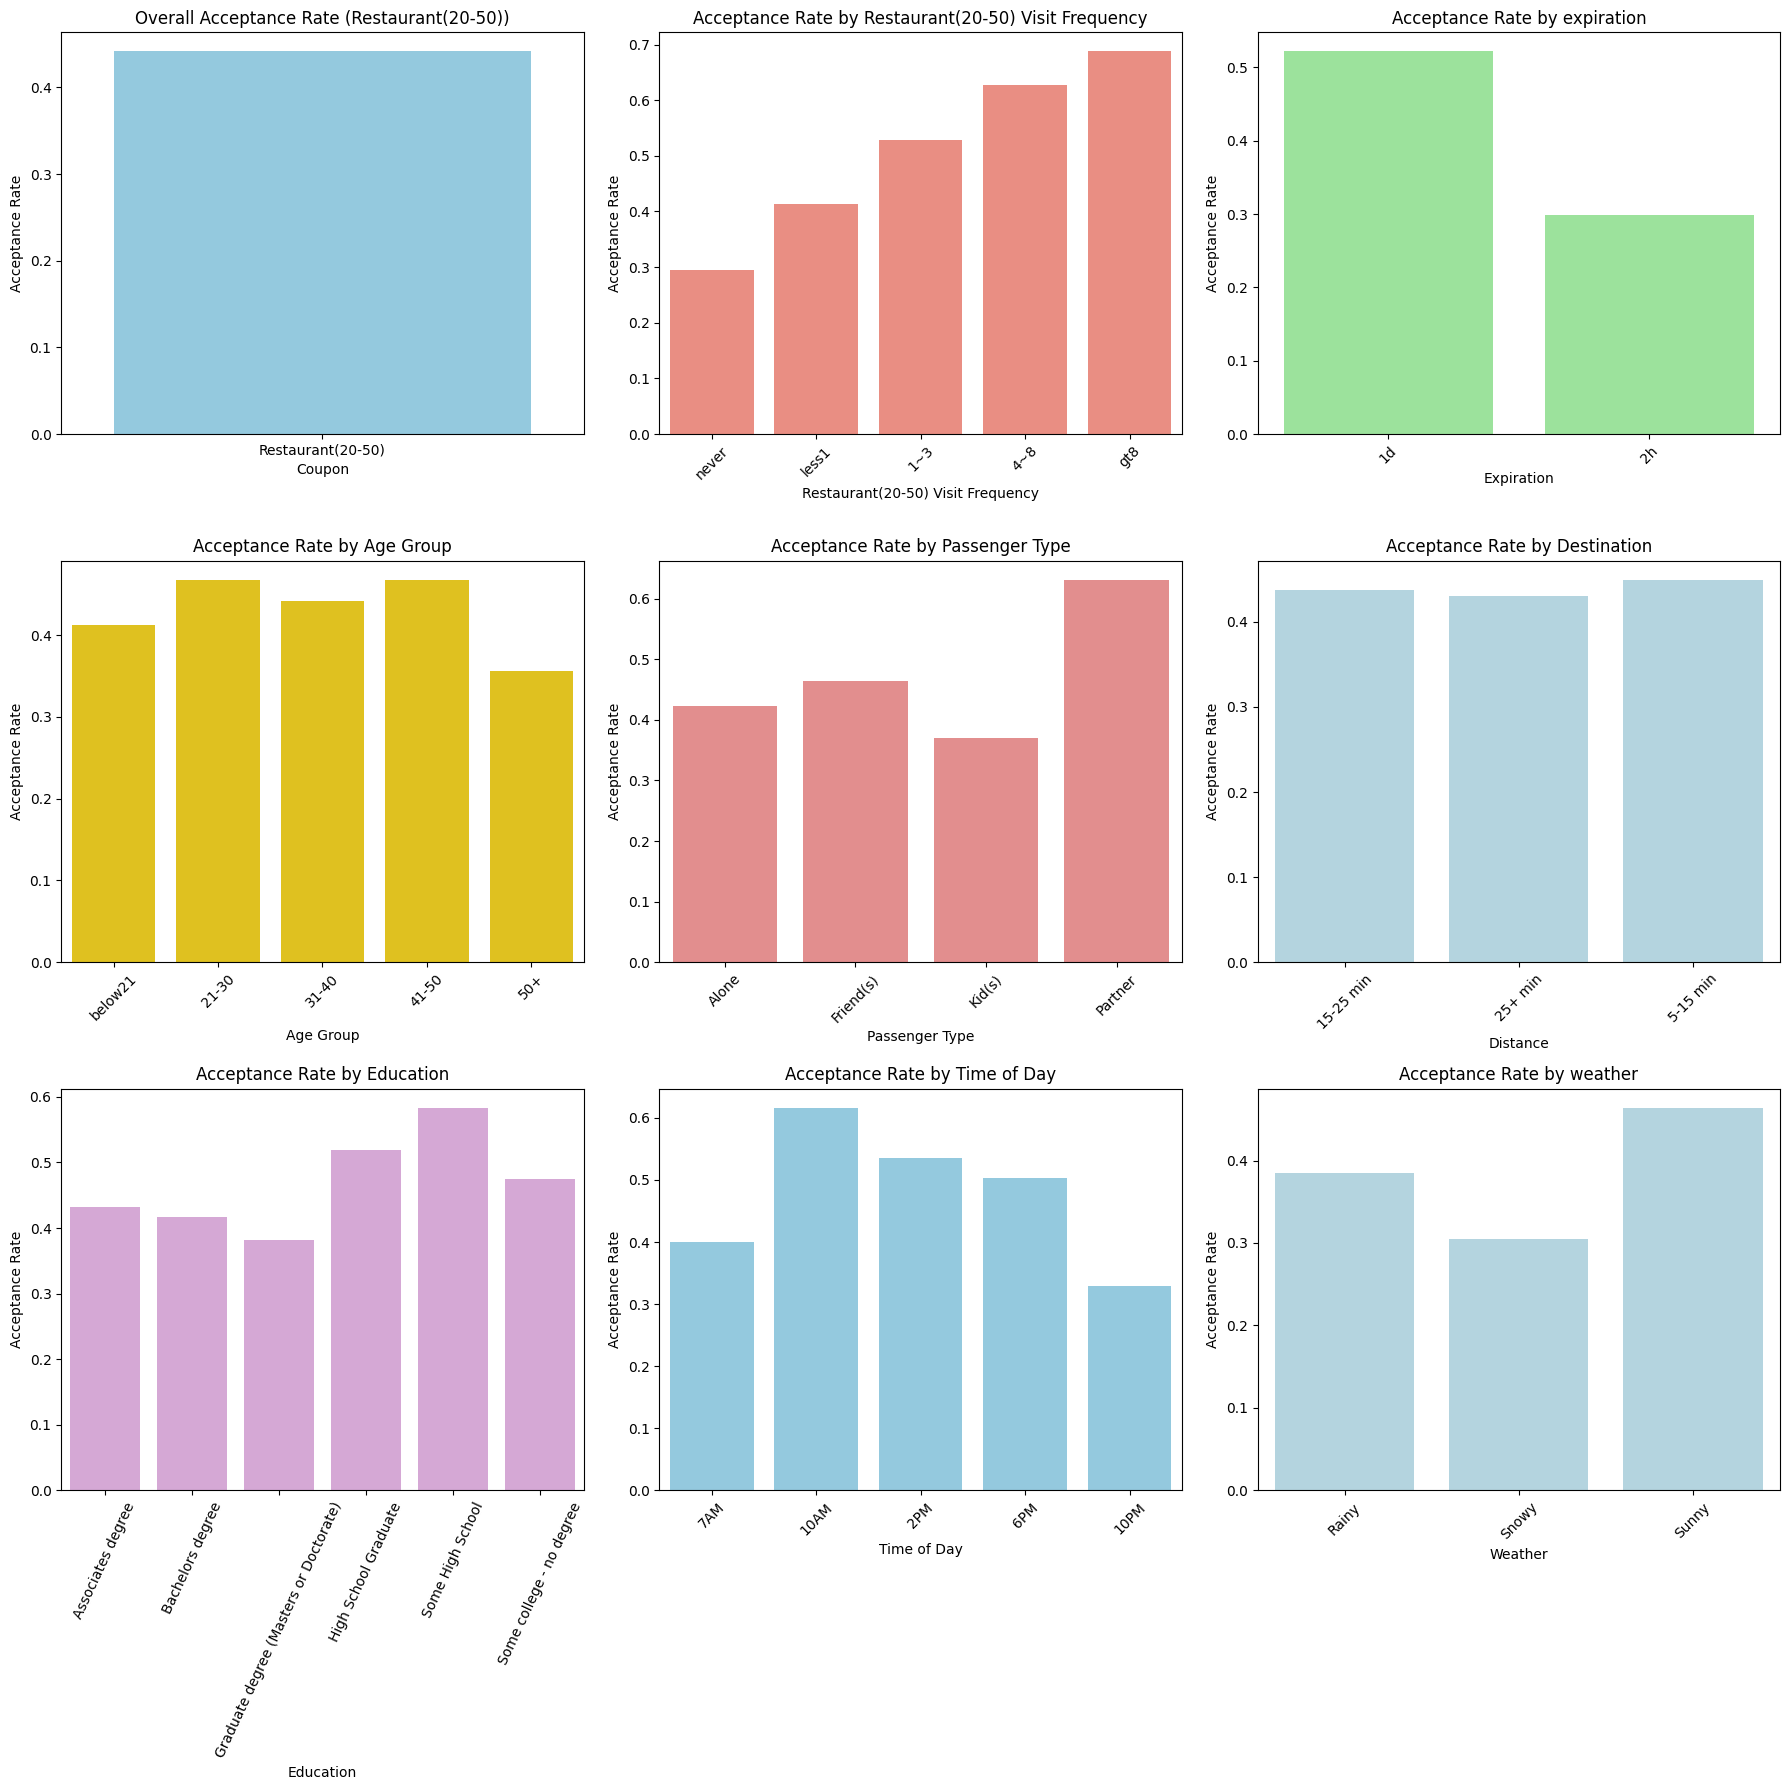

In [21]:
# Filter for Restaurant(20-50) coupons
resturant20_50subsetsubset = data.loc[data["coupon"] == "Restaurant(20-50)"]

# Calculate overall acceptance rate for Restaurant(20-50) coupons
group_acceptance_rates = resturant20_50subsetsubset.groupby('coupon')['Y'].mean()
acceptance_rates_by_frequency = resturant20_50subsetsubset.groupby('Restaurant20To50')['Y'].mean().reset_index()
acceptance_rates_by_income = resturant20_50subsetsubset.groupby('income')['Y'].mean().reset_index()
acceptance_rates_by_age = resturant20_50subsetsubset.groupby('age_group')['Y'].mean().reset_index()
acceptance_rates_by_passenger = resturant20_50subsetsubset.groupby('passanger')['Y'].mean().reset_index()
acceptance_rates_by_destination = resturant20_50subsetsubset.groupby('destination')['Y'].mean().reset_index()
acceptance_rates_by_education = resturant20_50subsetsubset.groupby('education')['Y'].mean().reset_index()
acceptance_rates_by_time = resturant20_50subsetsubset.groupby('time')['Y'].mean().reset_index()
acceptance_rates_by_distance = resturant20_50subsetsubset.groupby('distance')['Y'].mean().reset_index()
acceptance_rates_by_weather = resturant20_50subsetsubset.groupby('weather')['Y'].mean().reset_index()
acceptance_rates_by_expiration = resturant20_50subsetsubset.groupby('expiration')['Y'].mean().reset_index()
acceptance_rates_by_gender = resturant20_50subsetsubset.groupby('gender')['Y'].mean().reset_index()
acceptance_rates_by_occupation = resturant20_50subsetsubset.groupby('occupation')['Y'].mean().reset_index()
acceptance_rates_by_maritalStatus = resturant20_50subsetsubset.groupby('maritalStatus')['Y'].mean().reset_index()


print("Acceptance Rates:")
print(group_acceptance_rates)

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Subplot 1: Overall Acceptance Rate
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values, ax=axes[0, 0], color=colors[0])
axes[0, 0].set_title('Overall Acceptance Rate (Restaurant(20-50))')
axes[0, 0].set_xlabel('Coupon')
axes[0, 0].set_ylabel('Acceptance Rate')

# Subplot 2: Acceptance Rate by Visit Frequency
sns.barplot(x='Restaurant20To50', y='Y', data=acceptance_rates_by_frequency, order=frequency_order, ax=axes[0, 1], color=colors[1])
axes[0, 1].set_title('Acceptance Rate by Restaurant(20-50) Visit Frequency')
axes[0, 1].set_xlabel('Restaurant(20-50) Visit Frequency')
axes[0, 1].set_ylabel('Acceptance Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Subplot 3: Acceptance Rate by expiration
sns.barplot(x='expiration', y='Y', data=acceptance_rates_by_expiration,  ax=axes[0, 2], color=colors[2])
axes[0, 2].set_title('Acceptance Rate by expiration')
axes[0, 2].set_xlabel('Expiration')
axes[0, 2].set_ylabel('Acceptance Rate')
axes[0, 2].tick_params(axis='x', rotation=45)

# Subplot 4: Acceptance Rate by Age
sns.barplot(x='age_group', y='Y', data=acceptance_rates_by_age, order=age_order, ax=axes[1, 0], color=colors[3])
axes[1, 0].set_title('Acceptance Rate by Age Group')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('Acceptance Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# Subplot 5: Acceptance Rate by Passenger Type
sns.barplot(x='passanger', y='Y', data=acceptance_rates_by_passenger, ax=axes[1, 1], color=colors[4])
axes[1, 1].set_title('Acceptance Rate by Passenger Type')
axes[1, 1].set_xlabel('Passenger Type')
axes[1, 1].set_ylabel('Acceptance Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# Subplot 6: Acceptance Rate by Distance
sns.barplot(x='distance', y='Y', data=acceptance_rates_by_distance, ax=axes[1, 2], color=colors[5])
axes[1, 2].set_title('Acceptance Rate by Destination')
axes[1, 2].set_xlabel('Distance')
axes[1, 2].set_ylabel('Acceptance Rate')
axes[1, 2].tick_params(axis='x', rotation=45)

# Subplot 7: Acceptance Rate by Education
sns.barplot(x='education', y='Y', data=acceptance_rates_by_education, ax=axes[2, 0], color=colors[6])
axes[2, 0].set_title('Acceptance Rate by Education')
axes[2, 0].set_xlabel('Education')
axes[2, 0].set_ylabel('Acceptance Rate')
axes[2, 0].tick_params(axis='x', rotation=65)

# Subplot 8: Acceptance Rate by Time of Day
time_order = ['7AM', '10AM', '2PM', '6PM', '10PM']
sns.barplot(x='time', y='Y', data=acceptance_rates_by_time, order=time_order, ax=axes[2, 1], color=colors[0])
axes[2, 1].set_title('Acceptance Rate by Time of Day')
axes[2, 1].set_xlabel('Time of Day')
axes[2, 1].set_ylabel('Acceptance Rate')
axes[2, 1].tick_params(axis='x', rotation=45)

# Subplot 9: Acceptance Rate by Weather
sns.barplot(x='weather', y='Y', data=acceptance_rates_by_weather,  ax=axes[2, 2], color=colors[5])
axes[2, 2].set_title('Acceptance Rate by weather')
axes[2, 2].set_xlabel('Weather')
axes[2, 2].set_ylabel('Acceptance Rate')
axes[2, 2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Acceptance Rates:
coupon
Coffee House    0.498621
Name: Y, dtype: float64


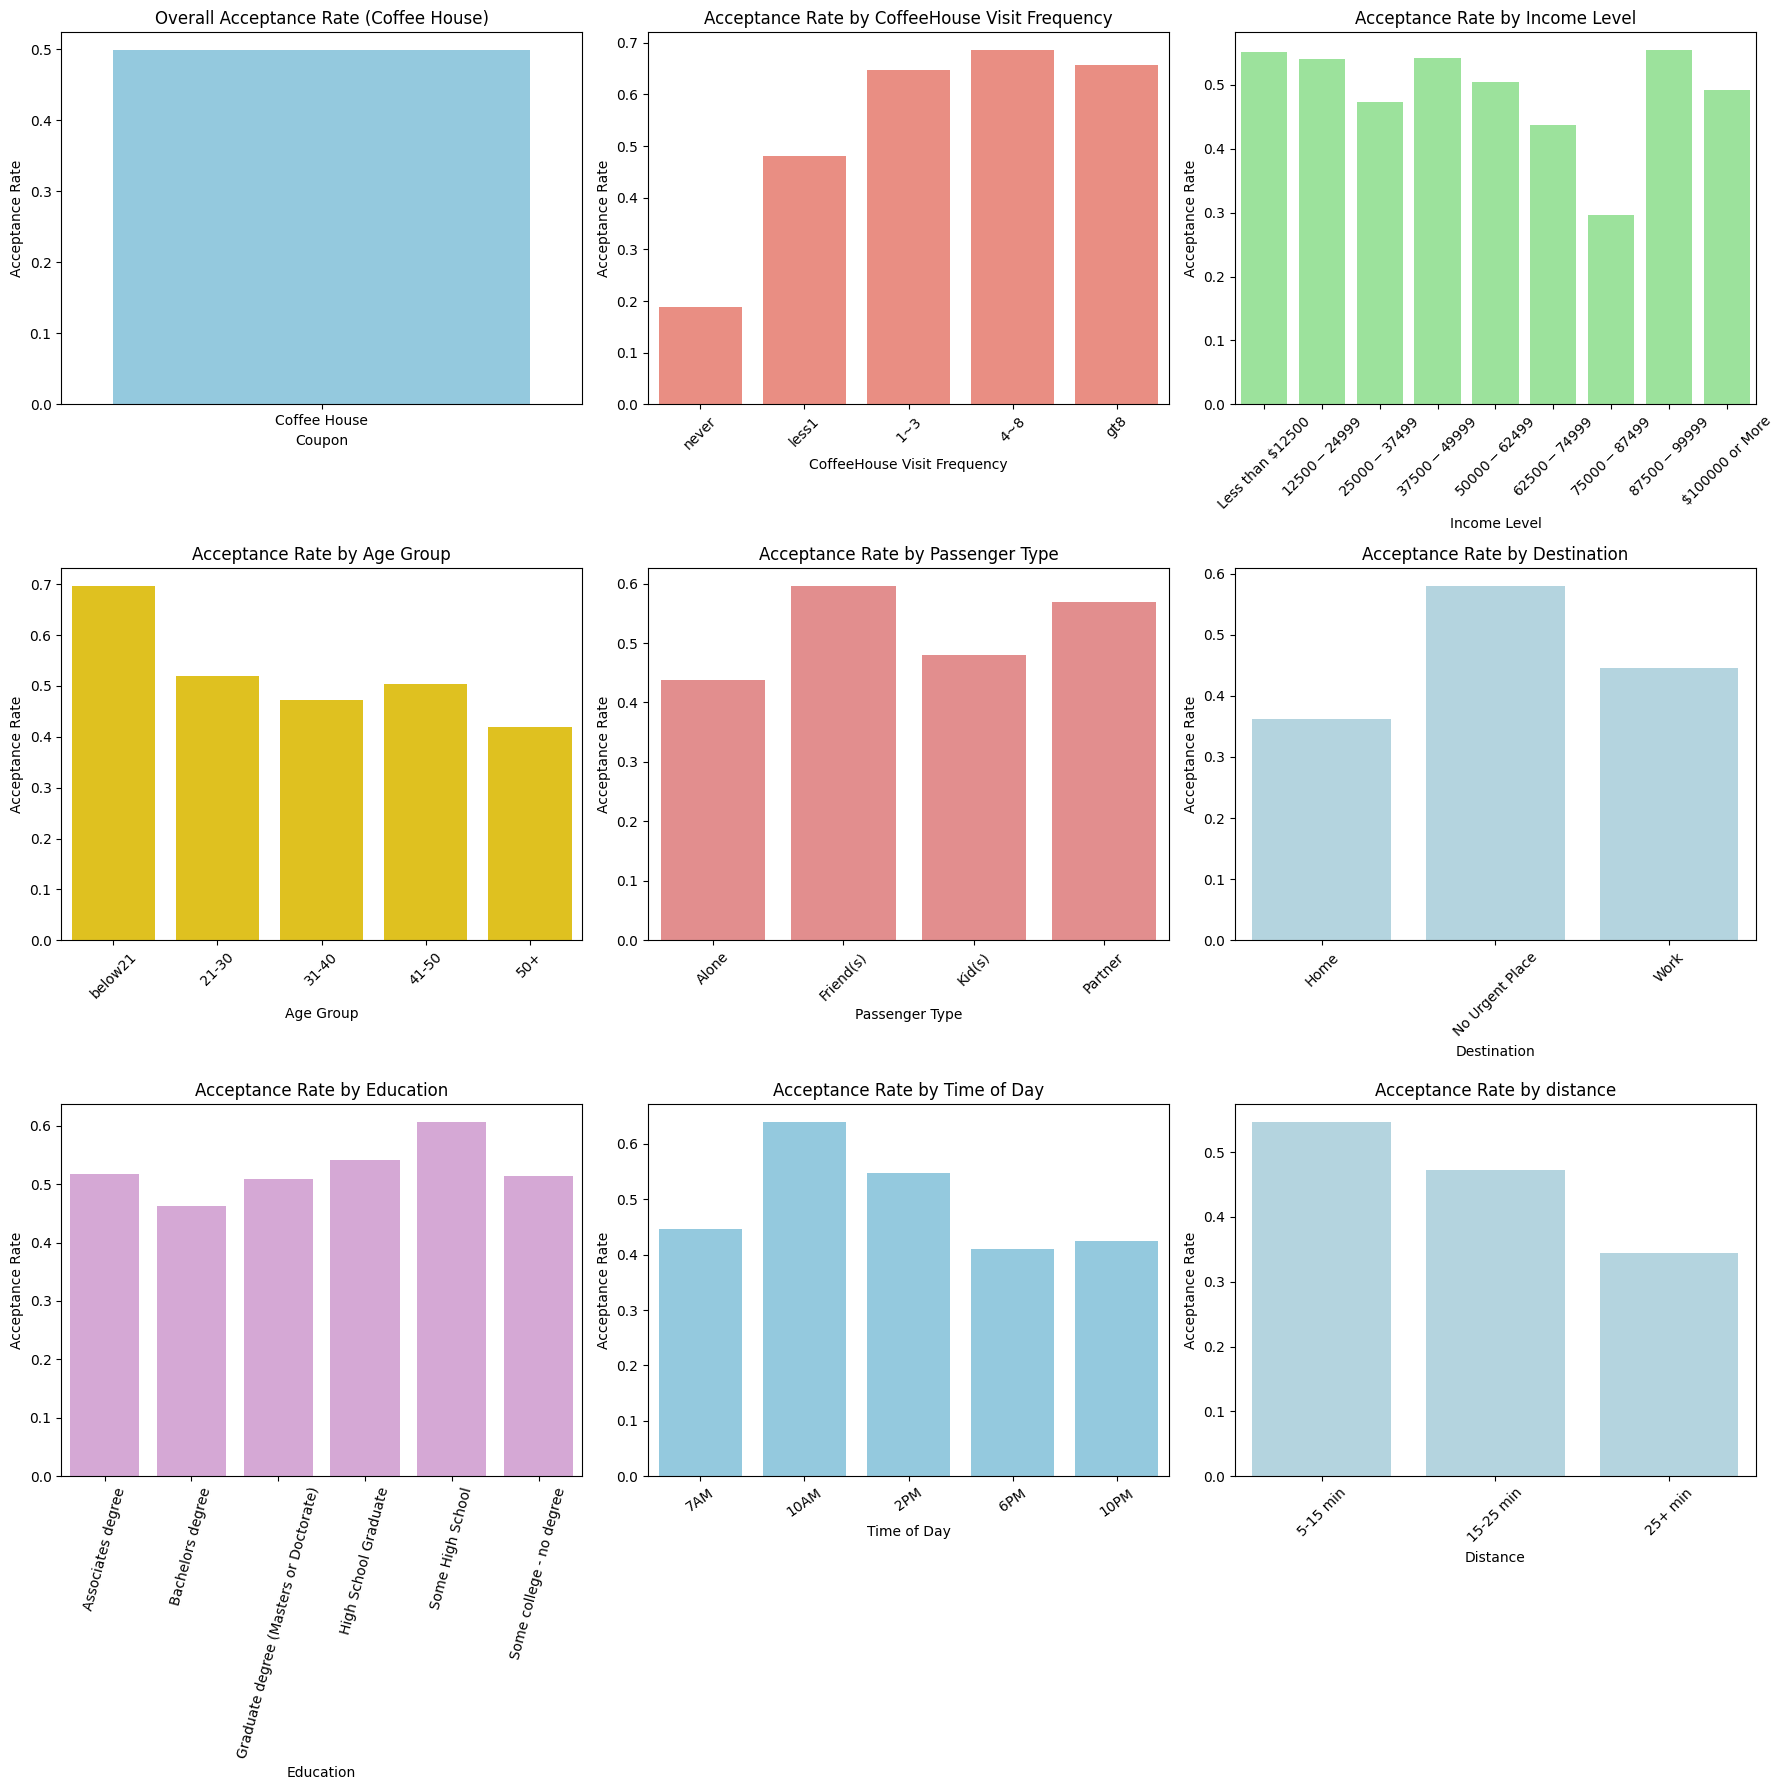

In [22]:
# Filter for Coffee House coupons
coffeesubset = data.loc[data["coupon"] == "Coffee House"]

# Calculate overall acceptance rate for Coffee House coupons
group_acceptance_rates = coffeesubset.groupby('coupon')['Y'].mean()
acceptance_rates_by_frequency = coffeesubset.groupby('CoffeeHouse')['Y'].mean().reset_index()
acceptance_rates_by_income = coffeesubset.groupby('income')['Y'].mean().reset_index()
acceptance_rates_by_age = coffeesubset.groupby('age_group')['Y'].mean().reset_index()
acceptance_rates_by_passenger = coffeesubset.groupby('passanger')['Y'].mean().reset_index()
acceptance_rates_by_destination = coffeesubset.groupby('destination')['Y'].mean().reset_index()
acceptance_rates_by_education = coffeesubset.groupby('education')['Y'].mean().reset_index()
acceptance_rates_by_time = coffeesubset.groupby('time')['Y'].mean().reset_index()
acceptance_rates_by_distance = coffeesubset.groupby('distance')['Y'].mean().reset_index()
acceptance_rates_by_weather = coffeesubset.groupby('weather')['Y'].mean().reset_index()
acceptance_rates_by_expiration = coffeesubset.groupby('expiration')['Y'].mean().reset_index()
acceptance_rates_by_gender = coffeesubset.groupby('gender')['Y'].mean().reset_index()
acceptance_rates_by_occupation = coffeesubset.groupby('occupation')['Y'].mean().reset_index()
acceptance_rates_by_maritalStatus = coffeesubset.groupby('maritalStatus')['Y'].mean().reset_index()

print("Acceptance Rates:")
print(group_acceptance_rates)


fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Subplot 1: Overall Acceptance Rate
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values, ax=axes[0, 0], color=colors[0])
axes[0, 0].set_title('Overall Acceptance Rate (Coffee House)')
axes[0, 0].set_xlabel('Coupon')
axes[0, 0].set_ylabel('Acceptance Rate')

# Subplot 2: Acceptance Rate by CoffeeHouse Visit Frequency
sns.barplot(x='CoffeeHouse', y='Y', data=acceptance_rates_by_frequency, order=frequency_order, ax=axes[0, 1], color=colors[1])
axes[0, 1].set_title('Acceptance Rate by CoffeeHouse Visit Frequency')
axes[0, 1].set_xlabel('CoffeeHouse Visit Frequency')
axes[0, 1].set_ylabel('Acceptance Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Subplot 3: Acceptance Rate by Income
income_order = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999',
    '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999',
    '$100000 or More'
]
sns.barplot(x='income', y='Y', data=acceptance_rates_by_income, order=income_order, ax=axes[0, 2], color=colors[2])
axes[0, 2].set_title('Acceptance Rate by Income Level')
axes[0, 2].set_xlabel('Income Level')
axes[0, 2].set_ylabel('Acceptance Rate')
axes[0, 2].tick_params(axis='x', rotation=45)

# Subplot 4: Acceptance Rate by Age
sns.barplot(x='age_group', y='Y', data=acceptance_rates_by_age, order=age_order, ax=axes[1, 0], color=colors[3])
axes[1, 0].set_title('Acceptance Rate by Age Group')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('Acceptance Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# Subplot 5: Acceptance Rate by Passenger Type
sns.barplot(x='passanger', y='Y', data=acceptance_rates_by_passenger, ax=axes[1, 1], color=colors[4])
axes[1, 1].set_title('Acceptance Rate by Passenger Type')
axes[1, 1].set_xlabel('Passenger Type')
axes[1, 1].set_ylabel('Acceptance Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# Subplot 6: Acceptance Rate by Destination
sns.barplot(x='destination', y='Y', data=acceptance_rates_by_destination, ax=axes[1, 2], color=colors[5])
axes[1, 2].set_title('Acceptance Rate by Destination')
axes[1, 2].set_xlabel('Destination')
axes[1, 2].set_ylabel('Acceptance Rate')
axes[1, 2].tick_params(axis='x', rotation=45)

# Subplot 7: Acceptance Rate by Education
sns.barplot(x='education', y='Y', data=acceptance_rates_by_education, ax=axes[2, 0], color=colors[6])
axes[2, 0].set_title('Acceptance Rate by Education')
axes[2, 0].set_xlabel('Education')
axes[2, 0].set_ylabel('Acceptance Rate')
axes[2, 0].tick_params(axis='x', rotation=75)

# Subplot 8: Acceptance Rate by Time of Day
time_order = ['7AM', '10AM', '2PM', '6PM', '10PM']
sns.barplot(x='time', y='Y', data=acceptance_rates_by_time, order=time_order, ax=axes[2, 1], color=colors[0])
axes[2, 1].set_title('Acceptance Rate by Time of Day')
axes[2, 1].set_xlabel('Time of Day')
axes[2, 1].set_ylabel('Acceptance Rate')
axes[2, 1].tick_params(axis='x', rotation=35)

# Subplot 9: Acceptance Rate by distance
sns.barplot(x='distance', y='Y', data=acceptance_rates_by_distance, order=distance_order, ax=axes[2, 2], color=colors[5])
axes[2, 2].set_title('Acceptance Rate by distance')
axes[2, 2].set_xlabel('Distance')
axes[2, 2].set_ylabel('Acceptance Rate')
axes[2, 2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()




Acceptance Rates:
coupon
Carry out & Take away    0.733788
Name: Y, dtype: float64


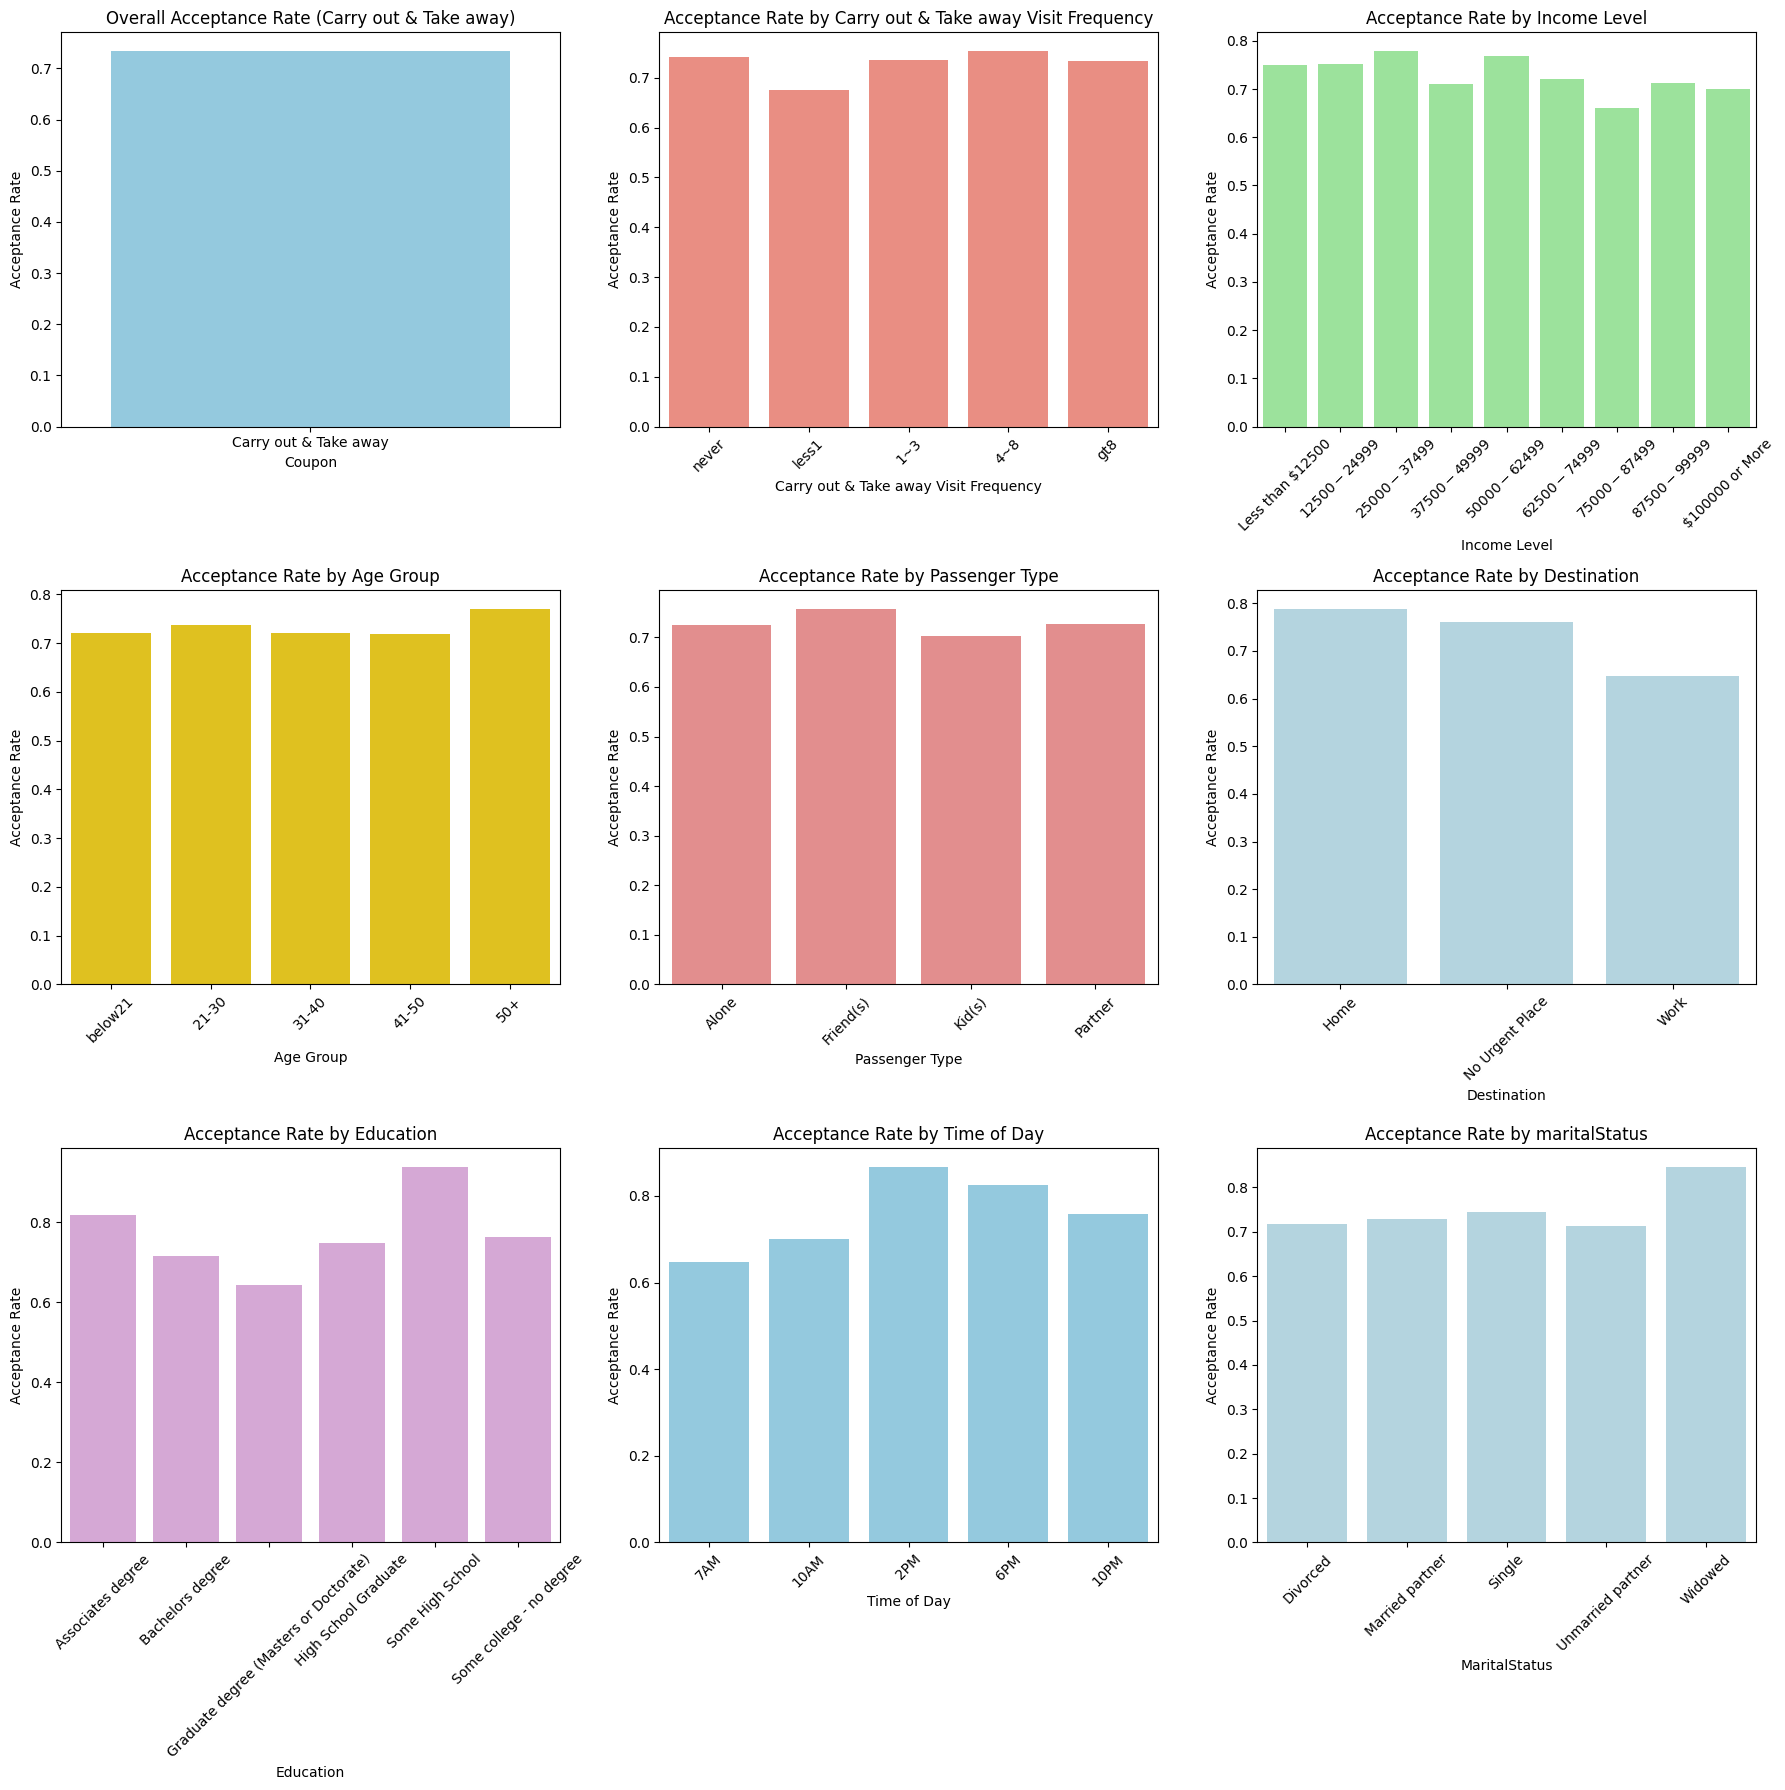

In [23]:
# Filter for Carry out & Take away coupons
carryawaysubsetsubset = data.loc[data["coupon"] == "Carry out & Take away"]
# Calculate overall acceptance rate for Carry out & Take away coupons
group_acceptance_rates = carryawaysubsetsubset.groupby('coupon')['Y'].mean()
acceptance_rates_by_frequency = carryawaysubsetsubset.groupby('CarryAway')['Y'].mean().reset_index()
acceptance_rates_by_income = carryawaysubsetsubset.groupby('income')['Y'].mean().reset_index()
acceptance_rates_by_age = carryawaysubsetsubset.groupby('age_group')['Y'].mean().reset_index()
acceptance_rates_by_passenger = carryawaysubsetsubset.groupby('passanger')['Y'].mean().reset_index()
acceptance_rates_by_destination = carryawaysubsetsubset.groupby('destination')['Y'].mean().reset_index()
acceptance_rates_by_education = carryawaysubsetsubset.groupby('education')['Y'].mean().reset_index()
acceptance_rates_by_time = carryawaysubsetsubset.groupby('time')['Y'].mean().reset_index()
acceptance_rates_by_distance = carryawaysubsetsubset.groupby('distance')['Y'].mean().reset_index()
acceptance_rates_by_weather = carryawaysubsetsubset.groupby('weather')['Y'].mean().reset_index()
acceptance_rates_by_expiration = carryawaysubsetsubset.groupby('expiration')['Y'].mean().reset_index()
acceptance_rates_by_gender = carryawaysubsetsubset.groupby('gender')['Y'].mean().reset_index()
acceptance_rates_by_occupation = carryawaysubsetsubset.groupby('occupation')['Y'].mean().reset_index()
acceptance_rates_by_maritalStatus = carryawaysubsetsubset.groupby('maritalStatus')['Y'].mean().reset_index()


print("Acceptance Rates:")
print(group_acceptance_rates)
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
# Subplot 1: Overall Acceptance Rate
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values, ax=axes[0, 0], color=colors[0])
axes[0, 0].set_title('Overall Acceptance Rate (Carry out & Take away)')
axes[0, 0].set_xlabel('Coupon')
axes[0, 0].set_ylabel('Acceptance Rate')

# Subplot 2: Acceptance Rate by CoffeeHouse Visit Frequency
sns.barplot(x='CarryAway', y='Y', data=acceptance_rates_by_frequency, order=frequency_order, ax=axes[0, 1], color=colors[1])
axes[0, 1].set_title('Acceptance Rate by Carry out & Take away Visit Frequency')
axes[0, 1].set_xlabel('Carry out & Take away Visit Frequency')
axes[0, 1].set_ylabel('Acceptance Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Subplot 3: Acceptance Rate by Income
income_order = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999',
    '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999',
    '$100000 or More'
]
sns.barplot(x='income', y='Y', data=acceptance_rates_by_income, order=income_order, ax=axes[0, 2], color=colors[2])
axes[0, 2].set_title('Acceptance Rate by Income Level')
axes[0, 2].set_xlabel('Income Level')
axes[0, 2].set_ylabel('Acceptance Rate')
axes[0, 2].tick_params(axis='x', rotation=45)

# Subplot 4: Acceptance Rate by Age
sns.barplot(x='age_group', y='Y', data=acceptance_rates_by_age, order=age_order, ax=axes[1, 0], color=colors[3])
axes[1, 0].set_title('Acceptance Rate by Age Group')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('Acceptance Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# Subplot 5: Acceptance Rate by Passenger Type
sns.barplot(x='passanger', y='Y', data=acceptance_rates_by_passenger, ax=axes[1, 1], color=colors[4])
axes[1, 1].set_title('Acceptance Rate by Passenger Type')
axes[1, 1].set_xlabel('Passenger Type')
axes[1, 1].set_ylabel('Acceptance Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# Subplot 6: Acceptance Rate by Destination
sns.barplot(x='destination', y='Y', data=acceptance_rates_by_destination, ax=axes[1, 2], color=colors[5])
axes[1, 2].set_title('Acceptance Rate by Destination')
axes[1, 2].set_xlabel('Destination')
axes[1, 2].set_ylabel('Acceptance Rate')
axes[1, 2].tick_params(axis='x', rotation=45)

# Subplot 7: Acceptance Rate by Education
sns.barplot(x='education', y='Y', data=acceptance_rates_by_education, ax=axes[2, 0], color=colors[6])
axes[2, 0].set_title('Acceptance Rate by Education')
axes[2, 0].set_xlabel('Education')
axes[2, 0].set_ylabel('Acceptance Rate')
axes[2, 0].tick_params(axis='x', rotation=45)

# Subplot 8: Acceptance Rate by Time of Day
time_order = ['7AM', '10AM', '2PM', '6PM', '10PM']
sns.barplot(x='time', y='Y', data=acceptance_rates_by_time, order=time_order, ax=axes[2, 1], color=colors[0])
axes[2, 1].set_title('Acceptance Rate by Time of Day')
axes[2, 1].set_xlabel('Time of Day')
axes[2, 1].set_ylabel('Acceptance Rate')
axes[2, 1].tick_params(axis='x', rotation=45)

# Subplot 9: Acceptance Rate by MaritalStatus
sns.barplot(x='maritalStatus', y='Y', data=acceptance_rates_by_maritalStatus,  ax=axes[2, 2], color=colors[5])
axes[2, 2].set_title('Acceptance Rate by maritalStatus')
axes[2, 2].set_xlabel('MaritalStatus')
axes[2, 2].set_ylabel('Acceptance Rate')
axes[2, 2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


Acceptance Rates:
coupon
Bar    0.40995
Name: Y, dtype: float64


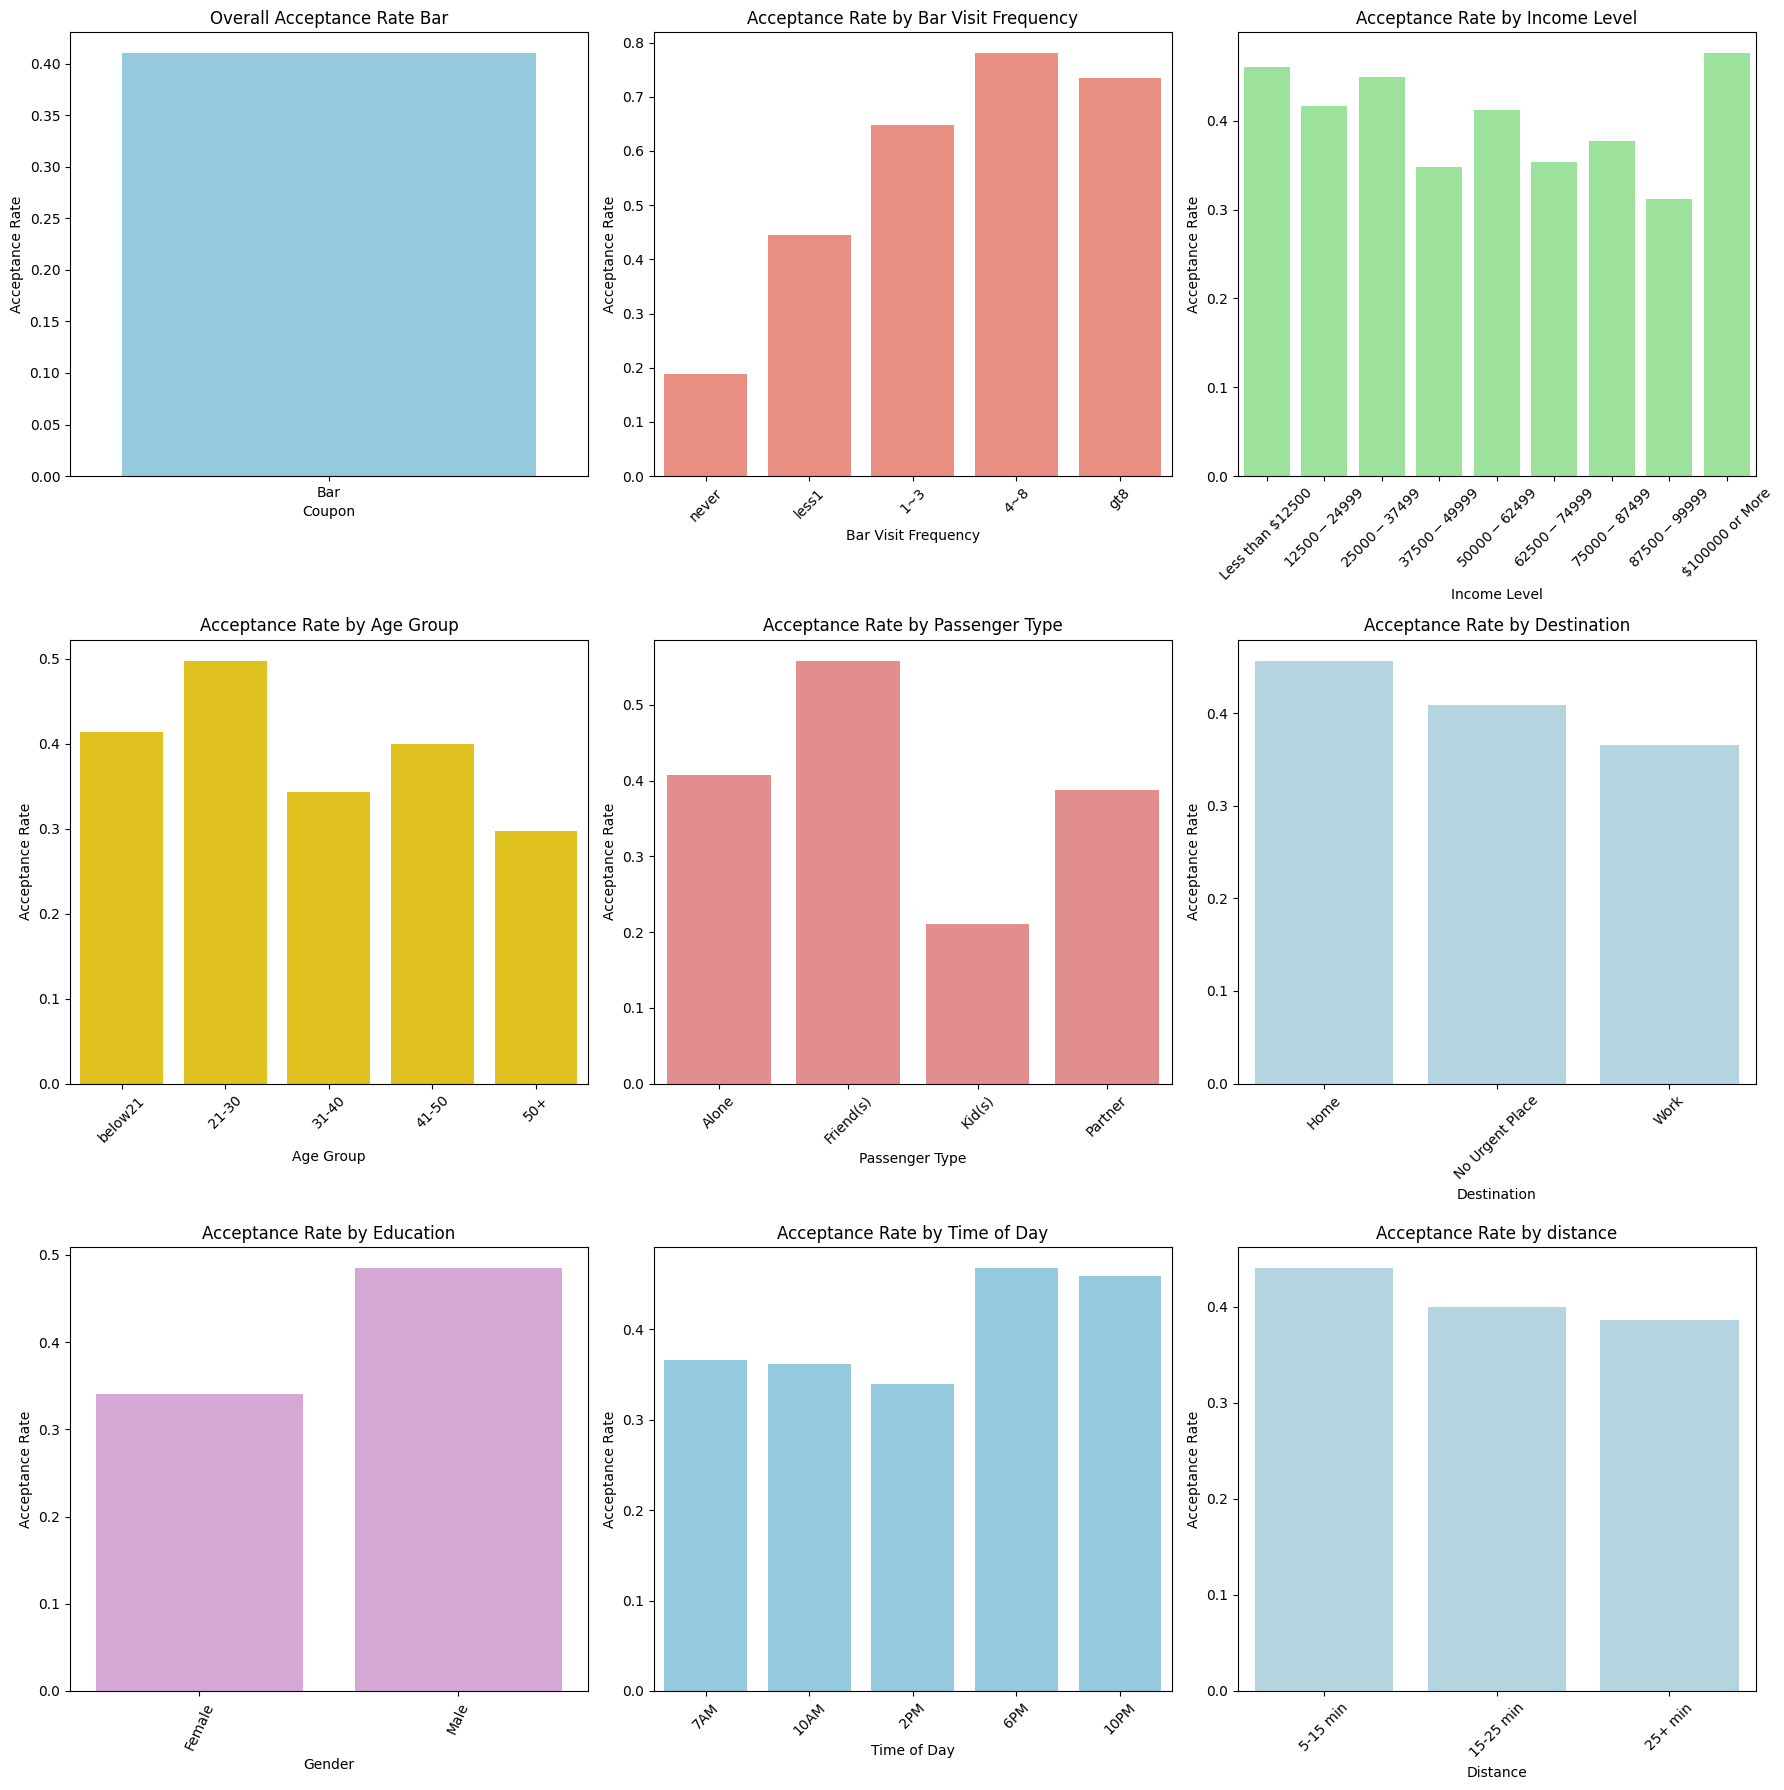

In [24]:
# Filter for Bar coupons
barsubsetsubset = data.loc[data["coupon"] == "Bar"]
# Calculate overall acceptance rate for Bar coupons
group_acceptance_rates = barsubsetsubset.groupby('coupon')['Y'].mean()
acceptance_rates_by_frequency = barsubsetsubset.groupby('Bar')['Y'].mean().reset_index()
acceptance_rates_by_income = barsubsetsubset.groupby('income')['Y'].mean().reset_index()
acceptance_rates_by_age = barsubsetsubset.groupby('age_group')['Y'].mean().reset_index()
acceptance_rates_by_passenger = barsubsetsubset.groupby('passanger')['Y'].mean().reset_index()
acceptance_rates_by_destination = barsubsetsubset.groupby('destination')['Y'].mean().reset_index()
acceptance_rates_by_education = barsubsetsubset.groupby('education')['Y'].mean().reset_index()
acceptance_rates_by_time = barsubsetsubset.groupby('time')['Y'].mean().reset_index()
acceptance_rates_by_distance = barsubsetsubset.groupby('distance')['Y'].mean().reset_index()
acceptance_rates_by_weather = barsubsetsubset.groupby('weather')['Y'].mean().reset_index()
acceptance_rates_by_expiration = barsubsetsubset.groupby('expiration')['Y'].mean().reset_index()
acceptance_rates_by_gender = barsubsetsubset.groupby('gender')['Y'].mean().reset_index()
acceptance_rates_by_occupation = barsubsetsubset.groupby('occupation')['Y'].mean().reset_index()
acceptance_rates_by_maritalStatus = barsubsetsubset.groupby('maritalStatus')['Y'].mean().reset_index()


print("Acceptance Rates:")
print(group_acceptance_rates)

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
# Subplot 1: Overall Acceptance Rate
sns.barplot(x=group_acceptance_rates.index, y=group_acceptance_rates.values, ax=axes[0, 0], color=colors[0])
axes[0, 0].set_title('Overall Acceptance Rate Bar')
axes[0, 0].set_xlabel('Coupon')
axes[0, 0].set_ylabel('Acceptance Rate')

# Subplot 2: Acceptance Rate by CoffeeHouse Visit Frequency
frequency_order = ['never', 'less1', '1~3', '4~8', 'gt8']
sns.barplot(x='Bar', y='Y', data=acceptance_rates_by_frequency, order=frequency_order, ax=axes[0, 1], color=colors[1])
axes[0, 1].set_title('Acceptance Rate by Bar Visit Frequency')
axes[0, 1].set_xlabel('Bar Visit Frequency')
axes[0, 1].set_ylabel('Acceptance Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Subplot 3: Acceptance Rate by Income
income_order = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999',
    '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999',
    '$100000 or More'
]
sns.barplot(x='income', y='Y', data=acceptance_rates_by_income, order=income_order, ax=axes[0, 2], color=colors[2])
axes[0, 2].set_title('Acceptance Rate by Income Level')
axes[0, 2].set_xlabel('Income Level')
axes[0, 2].set_ylabel('Acceptance Rate')
axes[0, 2].tick_params(axis='x', rotation=45)

# Subplot 4: Acceptance Rate by Age
sns.barplot(x='age_group', y='Y', data=acceptance_rates_by_age, order=age_order, ax=axes[1, 0], color=colors[3])
axes[1, 0].set_title('Acceptance Rate by Age Group')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('Acceptance Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# Subplot 5: Acceptance Rate by Passenger Type
sns.barplot(x='passanger', y='Y', data=acceptance_rates_by_passenger, ax=axes[1, 1], color=colors[4])
axes[1, 1].set_title('Acceptance Rate by Passenger Type')
axes[1, 1].set_xlabel('Passenger Type')
axes[1, 1].set_ylabel('Acceptance Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# Subplot 6: Acceptance Rate by Destination
sns.barplot(x='destination', y='Y', data=acceptance_rates_by_destination, ax=axes[1, 2], color=colors[5])
axes[1, 2].set_title('Acceptance Rate by Destination')
axes[1, 2].set_xlabel('Destination')
axes[1, 2].set_ylabel('Acceptance Rate')
axes[1, 2].tick_params(axis='x', rotation=45)

# Subplot 7: Acceptance Rate by Gender
sns.barplot(x='gender', y='Y', data=acceptance_rates_by_gender, ax=axes[2, 0], color=colors[6])
axes[2, 0].set_title('Acceptance Rate by Education')
axes[2, 0].set_xlabel('Gender')
axes[2, 0].set_ylabel('Acceptance Rate')
axes[2, 0].tick_params(axis='x', rotation=65)

# Subplot 8: Acceptance Rate by Time of Day
sns.barplot(x='time', y='Y', data=acceptance_rates_by_time, order=time_order, ax=axes[2, 1], color=colors[0])
axes[2, 1].set_title('Acceptance Rate by Time of Day')
axes[2, 1].set_xlabel('Time of Day')
axes[2, 1].set_ylabel('Acceptance Rate')
axes[2, 1].tick_params(axis='x', rotation=45)

# Subplot 9: Acceptance Rate by distance
sns.barplot(x='distance', y='Y', data=acceptance_rates_by_distance, order=distance_order, ax=axes[2, 2], color=colors[5])
axes[2, 2].set_title('Acceptance Rate by distance')
axes[2, 2].set_xlabel('Distance')
axes[2, 2].set_ylabel('Acceptance Rate')
axes[2, 2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()